In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from fbprophet import Prophet
from fbprophet.plot import plot_components_plotly, plot_forecast_component_plotly
import plotly.express as px
from IPython import display
import numpy as np

In [22]:
train = pd.read_csv('../data/train.csv',parse_dates=['date'], index_col='id')
test = pd.read_csv('../data/test.csv', parse_dates=['date'], index_col='id')
oil = pd.read_csv('../data/oil.csv', parse_dates=['date'])
holidays = pd.read_csv('../data/holidays_events.csv', parse_dates=['date'])
stores = pd.read_csv('../data/stores.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')
transactions = pd.read_csv('../data/transactions.csv', parse_dates=['date'])

In [189]:
train.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [190]:
train.shape

(3000888, 5)

In [191]:
train.tail()

,date,store_nbr,family,sales,onpromotion
id,,,,,
3000883,2017-08-15,9,POULTRY,438.133,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,2017-08-15,9,SEAFOOD,16.000,0


In [193]:
min_store_number = train['store_nbr'].min()
max_store_number = train['store_nbr'].max()
print("Store numbers range from: {} to {}".format(min_store_number, max_store_number))

Store numbers range from: 1 to 54


In [194]:
train['family'].nunique()

33

In [195]:
train['family'].value_counts()

AUTOMOTIVE                    90936
HOME APPLIANCES               90936
SCHOOL AND OFFICE SUPPLIES    90936
PRODUCE                       90936
PREPARED FOODS                90936
POULTRY                       90936
PLAYERS AND ELECTRONICS       90936
PET SUPPLIES                  90936
PERSONAL CARE                 90936
MEATS                         90936
MAGAZINES                     90936
LIQUOR,WINE,BEER              90936
LINGERIE                      90936
LAWN AND GARDEN               90936
LADIESWEAR                    90936
HOME CARE                     90936
HOME AND KITCHEN II           90936
BABY CARE                     90936
HOME AND KITCHEN I            90936
HARDWARE                      90936
GROCERY II                    90936
GROCERY I                     90936
FROZEN FOODS                  90936
EGGS                          90936
DELI                          90936
DAIRY                         90936
CLEANING                      90936
CELEBRATION                 

Family is a categorical column

In [196]:
unique_sales_values = train['sales'].nunique()
print("Unique sales values are: {}".format(unique_sales_values))

Unique sales values are: 379610


In [197]:
test.head()

,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0
3000889,2017-08-16,1,BABY CARE,0
3000890,2017-08-16,1,BEAUTY,2
3000891,2017-08-16,1,BEVERAGES,20
3000892,2017-08-16,1,BOOKS,0


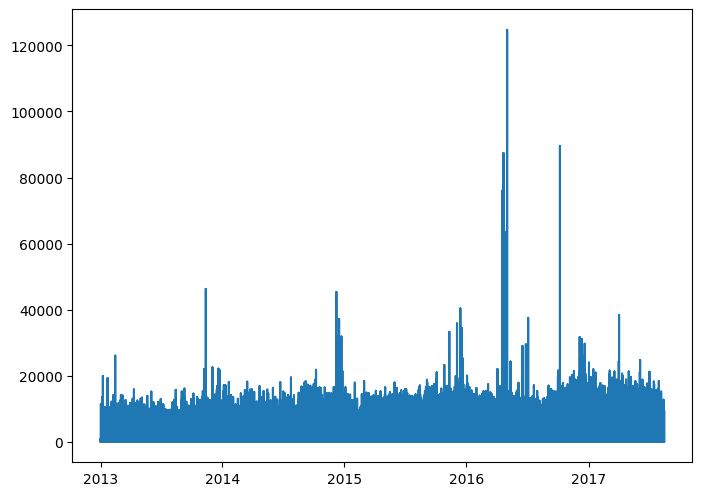

In [198]:
figure(figsize=(8, 6), dpi=100)
plt.plot(train['date'], train['sales'])

In [199]:
train['sales_rolling_avg'] = train['sales'].rolling(365).mean()

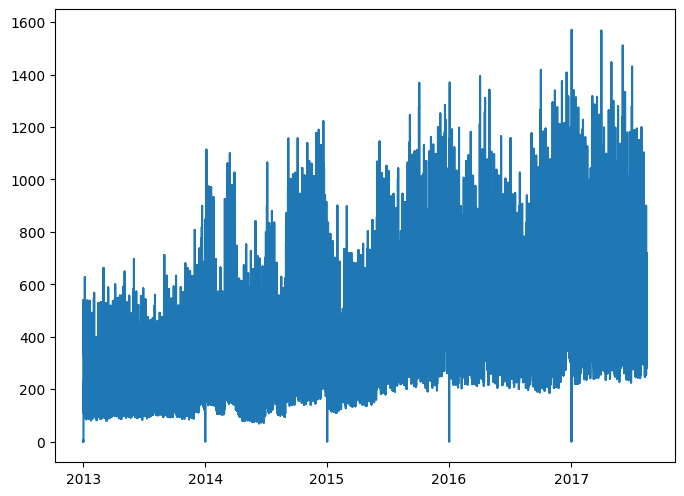

In [200]:
figure(figsize=(8, 6), dpi=100)
plt.plot(train['date'], train['sales_rolling_avg'])
train = train.drop('sales_rolling_avg', axis=1)

Daily sales on average

In [3]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [4]:
oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [23]:
df_data = train.copy()

df_data = df_data.merge(stores, how="left", on='store_nbr')

df_data = df_data.merge(oil, how="left", on='date')

df_data = df_data.merge(transactions, how="left", on=['date','store_nbr'])

df_data = df_data.merge(holidays,on='date',how='left')

df_data = df_data.rename(columns={'type_x' : 'store_type','type_y':'holiday_type'})



df_data.date = pd.to_datetime(df_data.date)

df_data['year'] = df_data['date'].dt.year

df_data['month'] = df_data['date'].dt.month

df_data['week'] = df_data['date'].dt.isocalendar().week

df_data['quarter'] = df_data['date'].dt.quarter

df_data['day_of_week'] = df_data['date'].dt.day_name()

df_data.head()

,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,...,holiday_type,locale,locale_name,description,transferred,year,month,week,quarter,day_of_week
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday
4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,...,Holiday,National,Ecuador,Primer dia del ano,False,2013,1,1,1,Tuesday


In [24]:
df_data['dcoilwtico'].isnull().sum()

955152

In [25]:
df_data.shape[0]

3054348

In [26]:
df_data['dcoilwtico'].isnull().sum()/df_data.shape[0]

0.31271878646441076

In [27]:
df_data.transactions = df_data.transactions.replace(np.nan,0)
df_data[['locale','locale_name', 'description']] = df_data[['locale','locale_name', 'description']].replace(np.nan,'')

df_data['holiday_type'] = df_data['holiday_type'].replace(np.nan,'Working Day')

df_data['transferred'] = df_data['transferred'].replace(np.nan,False)
df_data['dcoilwtico'] = df_data['dcoilwtico'].fillna(method='bfill')

In [28]:
df_data['dcoilwtico'].isnull().sum()/df_data.shape[0]

0.0

In [29]:
df_data.columns

Index(['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state',
       'store_type', 'cluster', 'dcoilwtico', 'transactions', 'holiday_type',
       'locale', 'locale_name', 'description', 'transferred', 'year', 'month',
       'week', 'quarter', 'day_of_week'],
      dtype='object')

In [30]:
drop_columns = ['description']
df_data = df_data.drop(columns=drop_columns)

In [31]:
df_data.to_csv('../data/master_dataset.csv', index=False)

In [34]:

in_csv = '../data/master_dataset.csv'
number_lines = sum(1 for row in (open(in_csv)))
rowsize = 600000
for i in range(1,number_lines,rowsize):
    df = pd.read_csv(in_csv,
          header=None,
          nrows = rowsize,#number of rows to read at each loop
          skiprows = i)#skip rows that have been read
    out_csv = '../data/master_splits/master_datatset_' + str(i) + '.csv'
    df.to_csv(out_csv,
          index=False,
          header=False,
          mode='a',
          chunksize=rowsize)

/var/folders/y4/122z4fsn16nbvvlm9clqs3nc0000gp/T/ipykernel_8408/4293868378.py:5: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(in_csv,
/var/folders/y4/122z4fsn16nbvvlm9clqs3nc0000gp/T/ipykernel_8408/4293868378.py:5: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(in_csv,
/var/folders/y4/122z4fsn16nbvvlm9clqs3nc0000gp/T/ipykernel_8408/4293868378.py:5: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(in_csv,
/var/folders/y4/122z4fsn16nbvvlm9clqs3nc0000gp/T/ipykernel_8408/4293868378.py:5: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(in_csv,
/var/folders/y4/122z4fsn16nbvvlm9clqs3nc0000gp/T/ipykernel_8408/4293868378.py:5: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on

In [202]:
train.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [203]:
sample_submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [204]:
sales_sum_by_family = train.groupby('family').sum('sales')

In [205]:
sales_sum_by_family.head()

,store_nbr,sales,onpromotion
family,,,
AUTOMOTIVE,2500740,554822.0,4783
BABY CARE,2500740,10051.0,53
BEAUTY,2500740,337893.0,13483
BEVERAGES,2500740,216954486.0,906958
BOOKS,2500740,6438.0,0


In [206]:
figure(figsize=(8,6), dpi=100)
px.bar(sales_sum_by_family, sales_sum_by_family.sales, labels=sales_sum_by_family.index)

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/plotly/express/_core.py:137: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



<Figure size 800x600 with 0 Axes>

In [207]:
train['unique_y'] = train['family'] + '_' + train['store_nbr'].astype('string')
test['unique_y'] = test['family'] + '_' + test['store_nbr'].astype('string')

In [208]:
train.head()

,date,store_nbr,family,sales,onpromotion,unique_y
id,,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0,AUTOMOTIVE_1
1,2013-01-01,1,BABY CARE,0.0,0,BABY CARE_1
2,2013-01-01,1,BEAUTY,0.0,0,BEAUTY_1
3,2013-01-01,1,BEVERAGES,0.0,0,BEVERAGES_1
4,2013-01-01,1,BOOKS,0.0,0,BOOKS_1


In [209]:
train = train.rename(columns={'date':'ds', 'sales':'y'})
test  = test.rename(columns={'date':'ds'})

In [210]:
train.head()

,ds,store_nbr,family,y,onpromotion,unique_y
id,,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0,AUTOMOTIVE_1
1,2013-01-01,1,BABY CARE,0.0,0,BABY CARE_1
2,2013-01-01,1,BEAUTY,0.0,0,BEAUTY_1
3,2013-01-01,1,BEVERAGES,0.0,0,BEVERAGES_1
4,2013-01-01,1,BOOKS,0.0,0,BOOKS_1


In [211]:
train.tail()

,ds,store_nbr,family,y,onpromotion,unique_y
id,,,,,,
3000883,2017-08-15,9,POULTRY,438.133,0,POULTRY_9
3000884,2017-08-15,9,PREPARED FOODS,154.553,1,PREPARED FOODS_9
3000885,2017-08-15,9,PRODUCE,2419.729,148,PRODUCE_9
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,SCHOOL AND OFFICE SUPPLIES_9
3000887,2017-08-15,9,SEAFOOD,16.000,0,SEAFOOD_9


In [212]:
test.head()

,ds,store_nbr,family,onpromotion,unique_y
id,,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0,AUTOMOTIVE_1
3000889,2017-08-16,1,BABY CARE,0,BABY CARE_1
3000890,2017-08-16,1,BEAUTY,2,BEAUTY_1
3000891,2017-08-16,1,BEVERAGES,20,BEVERAGES_1
3000892,2017-08-16,1,BOOKS,0,BOOKS_1


In [213]:
grouped_train = train.groupby('unique_y')
grouped_test = test.groupby('unique_y')

In [214]:
tests = dict()
trains = dict()
for (k,v) in grouped_train:
    trains[k] = v.drop(columns=['unique_y', 'onpromotion', 'family', 'store_nbr'])

In [215]:
for (k, v) in grouped_test:
    tests[k] = v.drop(columns=['unique_y', 'onpromotion', 'family', 'store_nbr'])

In [ ]:
output = pd.DataFrame()
for family in trains:
    print()
    print('-----------TRAINING FOR {}-------'.format(family))
    print()
    model = Prophet()
    model.add_country_holidays(country_name='BR')
    model.fit(trains[family])
    future_dates = tests[family][['ds']]
    future = model.predict(future_dates)
    future.index = tests[family].index
    output = pd.concat([output, future[['yhat']]], axis=0)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_1-------

Initial log joint probability = -22.3322


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2572.48   0.000105271       84.6341           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2572.59   6.44746e-06       75.6847      0.2944           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       2572.61   2.88572e-06        71.134   4.087e-08       0.001      337  LS failed, Hessian reset 
     251       2572.61   4.54134e-08       69.1142      0.1723      0.1723      347   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_10-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -11.7726
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3270.88   0.000483577       65.2945           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103        3270.9   0.000377921        130.71   3.893e-06       0.001      176  LS failed, Hessian reset 
     199       3271.05    0.00164861       79.7806           1           1      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       3271.06   9.07798e-05       87.0388   1.384e-06       0.001      347  LS failed, Hessian reset 
     283       3271.13   3.13034e-07       57.8913      0.6438      0.6438      455   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_11-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -34.4749
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2511.77   1.90728e-06       77.1857      0.4358      0.4358      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       2511.77   9.45103e-08       77.4567      0.5889      0.5889      142   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_12-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -44.5279
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2541.37   0.000452232       83.4918      0.4432      0.4432      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       2541.42   0.000331575       64.3776   4.739e-06       0.001      184  LS failed, Hessian reset 
     185        2541.5     1.099e-07        57.432      0.3877           1      293   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_13-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -32.7019
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2736.63   1.07934e-05       86.6322           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       2736.63   7.62713e-06       72.8102   8.667e-08       0.001      184  LS failed, Hessian reset 
     137       2736.63   1.63444e-07        75.652           1           1      211   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_14-------

Initial log joint probability = -7.97894
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          3563   0.000539898       109.361           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       3563.22   4.31294e-05       100.252   5.899e-07       0.001      289  LS failed, Hessian reset 
     199       3563.22   4.52137e-06       55.8636      0.4745      0.4745      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       3563.22   1.73386e-07       66.1088      0.3505           1      314   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_15-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -9.29326
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3479.95    0.00153907       102.064      0.3201           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3480.61   0.000429944       85.0763      0.2641      0.9058      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3480.68    0.00075624          83.5           1           1      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     327       3480.74   2.96618e-05       73.5232   3.856e-07       0.001      504  LS failed, Hessian reset 
     399       3480.78   6.75438e-05        72.093       1.333      0.4684      600   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     418       3480.78   5.86303e-07    

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_16-------

Initial log joint probability = -45.2974


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87        2432.7    0.00121783       98.2124   1.342e-05       0.001      147  LS failed, Hessian reset 
      99       2432.76   3.36803e-05       63.0795      0.3299      0.3299      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2433.04    0.00868449       95.1844           1           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275       2433.43   3.56901e-05       67.5633     5.2e-07       0.001      452  LS failed, Hessian reset 
     299       2433.44   1.22704e-05        61.586           1           1      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     315       2433.44   3.15674e-08       70.7604     0.04808           1      506   
Optimization terminated normally: 
  Convergence detected: rel

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_17-------

Initial log joint probability = -17.8465


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       2813.11   0.000558515       123.165   3.741e-06       0.001      146  LS failed, Hessian reset 
      99       2813.25    0.00019538       71.8585      0.3431           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       2813.28    2.0985e-06       72.1798   2.361e-08       0.001      291  LS failed, Hessian reset 
     179       2813.28    9.9163e-08       65.2114      0.2339           1      302   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_18-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -40.7243
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2499.06   0.000114523       75.2226      0.3916      0.3916      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       2499.59     0.0013752       102.777    1.34e-05       0.001      213  LS failed, Hessian reset 
     155       2499.83   8.58701e-05       78.4017    1.42e-06       0.001      263  LS failed, Hessian reset 
     192       2499.86   1.06585e-05       85.5693   1.295e-07       0.001      348  LS failed, Hessian reset 
     199       2499.86   7.16445e-06       90.3939      0.4409           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       2499.86   3.88225e-06       84.5143   4.713e-08       0.001      433  LS failed, Hessian reset 
     251       2499.86   2.11751e-08       88.5269      0.1886   

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_19-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -28.0784
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2601.53   4.95566e-05       60.5759      0.7849      0.7849      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       2601.53   2.89446e-07        68.965     0.07422           1      221   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_2-------

Initial log joint probability = -50.6604


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          2555   9.08354e-05       85.1088      0.4275      0.4275      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       2555.05   2.91593e-06        92.912   3.789e-08       0.001      283  LS failed, Hessian reset 
     199       2555.05   9.69462e-08       70.7714      0.3878           1      299   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_20-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -10.4718
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3358.81    0.00347692       113.993           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       3363.33   0.000283345       106.159   3.419e-06       0.001      258  LS failed, Hessian reset 
     199       3363.43   0.000332408        83.272           1           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     268       3364.33   0.000283549       108.441   3.966e-06       0.001      439  LS failed, Hessian reset 
     299       3365.11   0.000320135       96.9007      0.4466      0.4466      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     354       3365.26   0.000105533       64.8996   1.613e-06       0.001      590  LS failed, Hessian rese

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_21-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -17.6564
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2937.34    0.00352222       122.969      0.7193      0.7193      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2945.03   0.000797763       151.999      0.4379      0.4379      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2945.81   0.000366319       82.2507     0.05636      0.5365      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     300       2945.82   0.000642056        82.789   7.806e-06       0.001      403  LS failed, Hessian reset 
     335       2945.86   2.09659e-07       61.0637      0.5979      0.5979      451   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_22-------

Initial log joint probability = -11.3372


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3614.39    0.00204683       87.0817           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       3615.88   0.000667409       224.905    6.47e-06       0.001      219  LS failed, Hessian reset 
     195       3616.43   0.000133836       108.819   1.114e-06       0.001      318  LS failed, Hessian reset 
     199       3616.44   0.000103367       86.1594           1           1      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280       3616.74   0.000552037       90.6488   8.396e-06       0.001      459  LS failed, Hessian reset 
     299       3616.84   0.000263512       75.4316       0.888       0.888      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     367       3617.02    2.8638e-08  

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_23-------

Initial log joint probability = -31.3147


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2635.8   1.63405e-05       74.4059           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       2635.81   7.05391e-05        85.203   8.554e-07       0.001      228  LS failed, Hessian reset 
     199       2635.82   4.57075e-06       69.8647       2.187      0.4878      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       2635.82   1.46869e-07       62.1622      0.5179      0.5179      358   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_24-------

Initial log joint probability = -11.3366


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3423.69   0.000957859       110.265           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       3424.39   0.000353254       143.602   3.588e-06       0.001      186  LS failed, Hessian reset 
     179       3424.86   0.000242188       122.408   2.745e-06       0.001      304  LS failed, Hessian reset 
     199       3424.92   1.38982e-05       79.1158           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     265       3424.93    4.9547e-08        73.476       0.188       0.188      414   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_25-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -22.1534
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2929.78   0.000377571       74.6589           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       2930.31    0.00115178       183.954   1.215e-05       0.001      320  LS failed, Hessian reset 
     199       2930.37    0.00020742       59.5824      0.7332      0.7332      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       2930.49   3.91735e-05       72.7557   5.831e-07       0.001      431  LS failed, Hessian reset 
     263       2930.49   1.40526e-05       84.6738   2.017e-07       0.001      487  LS failed, Hessian reset 
     299       2930.49   6.98605e-07       65.5099      0.7526      0.7526      530   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_26-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -34.8266
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2453.14    0.00118826       86.9601           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       2453.29   2.16622e-06       77.3439   2.726e-08       0.001      286  LS failed, Hessian reset 
     199       2453.29   1.80497e-07       53.6831      0.4946           1      294   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_27-------

Initial log joint probability = -27.9158
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2764.44   0.000989893       79.6391           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176        2764.9   0.000655709       142.477   5.539e-06       0.001      272  LS failed, Hessian reset 
     199       2764.96   1.73238e-05       78.7838      0.4558      0.4558      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280       2765.02    2.5998e-05       83.6465   2.713e-07       0.001      452  LS failed, Hessian reset 
     299       2765.02   2.73806e-07       67.2267      0.4064      0.4064      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     383       2765.03   1.89269e-06       65.1733   2.135e-0

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_28-------

Initial log joint probability = -25.707


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2893.94   0.000330243       52.3279       1.059      0.2457      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       2894.27   1.95863e-05       67.7686   3.359e-07       0.001      278  LS failed, Hessian reset 
     199       2894.27    2.5173e-06       54.1532       1.205      0.2691      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       2894.27   1.30847e-07       69.4974      0.5028           1      312   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_29-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -18.7108
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2867.29     0.0017401        107.94      0.2488           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       2869.09    0.00039397       63.1338   2.241e-06       0.001      198  LS failed, Hessian reset 
     159       2870.33   0.000378864       107.131   4.711e-06       0.001      278  LS failed, Hessian reset 
     199        2870.6    0.00089456        75.958      0.9138      0.9138      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       2870.89     0.0010081       165.191   1.052e-05       0.001      391  LS failed, Hessian reset 
     241       2871.15   0.000104288       72.5101   1.169e-06       0.001      466  LS failed, Hessian reset 
     273       2871.16   1.11413e-07       68.2653      0.2265   

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_3-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -16.3232
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3213.35     0.0023956       87.1662           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       3214.11     0.0016331       185.527   1.314e-05       0.001      285  LS failed, Hessian reset 
     199       3214.16   0.000302779       78.1951        0.95        0.95      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3214.26   0.000164102       62.9171       1.895      0.3933      418   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     365       3214.26   1.87325e-07        76.038     0.03935           1      502   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_30-------

Initial log joint probability = -30.3535


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       2312.42   0.000390965       69.8367   4.316e-06       0.001      122  LS failed, Hessian reset 
      99       2312.45   1.07859e-06       68.9195      0.5259      0.5259      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       2312.45   1.26037e-07       69.1925      0.1893      0.9936      176   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_31-------

Initial log joint probability = -28.1045


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       2763.09   0.000858514       164.488   9.015e-06       0.001      141  LS failed, Hessian reset 
      99        2763.3   0.000285102       80.6165      0.2957           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       2763.67     0.0013355       110.833   1.361e-05       0.001      249  LS failed, Hessian reset 
     199       2763.79    0.00113778       86.6371      0.3715           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     259       2763.86   9.83602e-06       87.8716   1.122e-07       0.001      457  LS failed, Hessian reset 
     278       2763.86   1.46668e-07       75.4903      0.9682      0.9682      485   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_32-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -41.4062
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       2380.69   6.25196e-05        74.482   8.011e-07       0.001      152  LS failed, Hessian reset 
      99       2380.69   3.26516e-06       66.1798        0.51        0.51      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       2380.69   2.27584e-07         65.37      0.5956      0.5956      199   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_33-------

Initial log joint probability = -16.3754
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69          3069    0.00109633       194.116   7.649e-06       0.001      130  LS failed, Hessian reset 
      99       3069.08   3.84372e-06       67.5983           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       3069.09   1.17746e-07       73.2086      0.2254       0.729      236   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_34-------

Initial log joint probability = -6.45126


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3746.64   6.73981e-05       79.1818           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       3746.68   8.95758e-05       88.5805   1.283e-06       0.001      237  LS failed, Hessian reset 
     181       3746.72     2.527e-07       67.4499      0.4671      0.4671      325   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_35-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -14.8942
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3109.66    7.4453e-05       51.5963      0.3481      0.3481      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       3110.18   0.000326193       90.5013   3.876e-06       0.001      239  LS failed, Hessian reset 
     199       3110.19   8.06581e-06       74.7893           1           1      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       3110.19   9.89442e-07       64.1505   1.383e-08       0.001      350  LS failed, Hessian reset 
     228       3110.19    7.7715e-08       58.6869      0.4595      0.4595      358   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_36-------

Initial log joint probability = -42.0309


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       2421.76    0.00224251       102.029    2.61e-05       0.001      141  LS failed, Hessian reset 
      99       2422.14   0.000684569       66.9897           1           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2422.38   0.000281087       83.7265        0.46        0.46      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2422.45   0.000208883       88.3309      0.7255      0.7255      403   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     373        2422.5    1.7168e-05       94.0441   2.039e-07       0.001      528  LS failed, Hessian reset 
     399       2422.51   3.53525e-05       70.0303      0.5831      0.5831      558   
    Iter      log prob        ||dx||      ||grad||       alpha

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_37-------

Initial log joint probability = -8.13933


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3819.49   0.000820515       76.9873           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       3819.59   0.000288076       84.7999   3.625e-06       0.001      181  LS failed, Hessian reset 
     157       3819.61   2.79754e-06       75.4931   3.638e-08       0.001      277  LS failed, Hessian reset 
     165       3819.61   1.63589e-07       58.5275      0.5788      0.5788      286   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_38-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -18.4886
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       3207.26   0.000190511       83.5876   2.525e-06       0.001      121  LS failed, Hessian reset 
      99        3207.5   0.000817958       71.0457      0.5669      0.5669      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3207.78   1.21419e-05       58.9317      0.2585      0.2585      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     268       3208.07   0.000239283       82.7003   2.269e-06       0.001      438  LS failed, Hessian reset 
     299       3208.08    3.4519e-07       84.8287       0.213           1      483   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     302       3208.08   1.95118e-07       76.8737       0.205           1      487   
Optimization terminat

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_39-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -3.70353
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       4887.47   0.000113158       194.082   1.372e-06       0.001      172  LS failed, Hessian reset 
      99       4887.47   5.01214e-05       92.1544           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       4887.53   5.17664e-05       131.305   3.804e-07       0.001      289  LS failed, Hessian reset 
     198       4887.54   1.04492e-07        58.631      0.1303      0.4261      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_4-------

Initial log joint probability = -22.8923
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2713.63    0.00122784       89.0108      0.3121           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       2714.41    0.00124467       196.007    1.09e-05       0.001      214  LS failed, Hessian reset 
     199       2714.67   2.12134e-05       65.6368           1           1      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       2714.69   9.56592e-05       84.9128    1.27e-06       0.001      352  LS failed, Hessian reset 
     299       2714.73   0.000181205       67.9146           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     344       2714.83   0.000150493       79.4163   1.998e-06

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



     70.4149      0.9282      0.9282      632   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     403       2714.88   4.03311e-05       94.5712   4.944e-07       0.001      675  LS failed, Hessian reset 
     451       2714.88    8.6371e-08        78.336      0.3255           1      735   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_40-------

Initial log joint probability = -27.4442


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       2463.53     1.358e-07       57.8032      0.3082      0.7347      121   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_41-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -25.824
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       2591.72   0.000522509       69.3416   7.031e-06       0.001      143  LS failed, Hessian reset 
      99       2591.74   4.45125e-05       81.2429      0.6551      0.6551      150   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199          2592   4.48732e-05       76.3767      0.5239      0.5239      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     268       2592.05    7.8342e-07       72.5213   9.257e-09       0.001      400  LS failed, Hessian reset 
     271       2592.05   1.16581e-07       56.2072      0.3217           1      404   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_42-------

Initial log joint probability = -15.9477


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2889.84   0.000443926       157.138       0.521       0.521      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2892.56   1.62655e-07       78.5098     0.07538      0.4191      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       2892.56   4.11396e-07       73.2962           1           1      255   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_43-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -47.6159
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2593.45    0.00057512       76.6126       0.537       0.537      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       2593.89   1.66213e-07       65.2707           1           1      252   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_44-------

Initial log joint probability = -28.8204


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       3203.14     0.0010638       101.978    1.22e-05       0.001      153  LS failed, Hessian reset 
      99       3203.16   0.000346355       77.6424       3.203      0.3203      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3203.47   1.31204e-06        61.858      0.3466      0.3466      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     254       3203.47   2.10594e-07        60.499           1           1      357   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_45-------

Initial log joint probability = -45.6564


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       2840.34   0.000193488       51.5917   3.589e-06       0.001      130  LS failed, Hessian reset 
      99       2840.42   8.07593e-06       64.5905      0.3233           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       2840.45    0.00030981       74.9686   4.808e-06       0.001      285  LS failed, Hessian reset 
     189       2840.47   1.38003e-05         71.33   1.988e-07       0.001      372  LS failed, Hessian reset 
     199       2840.48   9.44508e-07       58.9516     0.03437           1      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       2840.48    7.0523e-07       63.2714       1.093      0.3689      415   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_46-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -34.5487
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      57       2906.72   0.000232597       69.2148   2.801e-06       0.001      116  LS failed, Hessian reset 
      99       2907.58   0.000423048       32.7253           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       2907.68   0.000138196       35.0081   2.112e-06       0.001      257  LS failed, Hessian reset 
     169       2907.87   0.000460287       99.5488   6.466e-06       0.001      335  LS failed, Hessian reset 
     199       2907.91    0.00194622       85.0134           1           1      377   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       2908.19   0.000826053       55.9859   1.492e-05       0.001      525  LS failed, Hessian reset 
     282       2908.21   2.64838e-05       29.6108   4.619e-07   

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_47-------

Initial log joint probability = -68.1707


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2831.6    2.7295e-05       51.4012      0.2442      0.2442      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       2831.68   0.000180748       78.5779   2.331e-06       0.001      230  LS failed, Hessian reset 
     198        2831.7   6.79553e-06       79.9783    9.22e-08       0.001      338  LS failed, Hessian reset 
     199        2831.7   4.01667e-06       80.5539           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217        2831.7    1.8616e-07       73.6661        1.15       0.115      363   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_48-------

Initial log joint probability = -53.6805


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2819.12    0.00267092       78.2858           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2820.46    0.00105652       89.9641           1           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2820.91   0.000116429       61.2477       0.333       0.333      389   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     320       2820.99   0.000378924       77.4742   4.701e-06       0.001      450  LS failed, Hessian reset 
     399        2821.2   0.000604358       55.1047           1           1      554   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     443       2821.23   6.71646e-08         40.66      0.1178           1      6

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_49-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -33.248
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       2616.89   0.000478999       83.0214   5.522e-06       0.001      108  LS failed, Hessian reset 
      99       2616.93   6.80106e-07       83.2887      0.9326      0.9326      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       2616.94    2.9611e-05       73.6677   3.733e-07       0.001      221  LS failed, Hessian reset 
     137       2616.94   3.05469e-07        80.374           1           1      249   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_5-------

Initial log joint probability = -36.7207
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       2355.66    0.00131286       162.706   1.088e-05       0.001      136  LS failed, Hessian reset 
      99       2356.26    0.00012356       86.6626      0.5788      0.5788      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       2356.93    0.00156025        180.85   1.431e-05       0.001      277  LS failed, Hessian reset 
     199        2357.2   2.98707e-05       71.2358      0.4632      0.4632      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     264       2357.21   1.27992e-07       74.0171       0.698       0.698      410   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_50-------

Initial log joint probability = -21.851


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3243.96   0.000512952       78.2211      0.3365      0.2812      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182        3244.2   0.000440898       74.1013   7.779e-06       0.001      292  LS failed, Hessian reset 
     199       3244.24     2.985e-05       49.1132      0.2197           1      313   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     283       3244.29   1.41787e-05       62.7762   2.045e-07       0.001      460  LS failed, Hessian reset 
     299       3244.29    5.6177e-07       53.5142           1           1      488   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303       3244.29   4.22639e-08       61.1961     0.04446           1      497   
Optimization terminated normally: 
  Convergence detected: rel

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_51-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -29.1514
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2605.3    0.00165027       87.8152      0.3041      0.7531      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       2605.87   0.000913008       157.845   7.234e-06       0.001      216  LS failed, Hessian reset 
     190       2606.04   5.40315e-05        91.907   6.611e-07       0.001      313  LS failed, Hessian reset 
     199       2606.04   1.61737e-06       76.1785      0.5974      0.5974      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       2606.04   8.01562e-08       83.4482      0.1354      0.5127      343   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_52-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -11.1726
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3551.21    0.00992418       247.156      0.3667      0.3667      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159        3568.8    0.00058299       188.009   9.262e-07       0.001      227  LS failed, Hessian reset 
     199        3575.3     0.0296327       294.455           1           1      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3582.65    0.00126047       136.406      0.5173      0.5173      397   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3591.01   3.54602e-05       71.3185      0.6552      0.6552      521   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     458       3591.12   6.43436e-05    

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_53-------

Initial log joint probability = -15.7049


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94        2953.1   0.000704427       166.138   6.524e-06       0.001      145  LS failed, Hessian reset 
      99       2953.32   0.000632456       74.8406      0.6907      0.6907      150   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2954.27    3.4316e-05        58.805           1           1      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     285        2954.5   0.000165891       66.4813   2.048e-06       0.001      423  LS failed, Hessian reset 
     299       2954.52    4.2979e-05       50.9726      0.2057           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     384       2955.48   0.000805012       200.478   3.861e-06       0.001      597  LS failed, Hessian reset 
     399       2956.31   0.000621147  

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_54-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -30.9834
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       2424.74    0.00079161       117.452   6.863e-06       0.001      126  LS failed, Hessian reset 
      99       2424.94   2.31199e-05       67.7596      0.5121      0.5121      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2425.17   1.21909e-07       76.2136      0.4618      0.4618      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     265       2425.25   8.11285e-05       66.5992   9.071e-07       0.001      427  LS failed, Hessian reset 
     299       2425.27   3.46605e-05       61.0048           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        2425.3   2.27413e-05       76.9475       2.459      0.2459      587   
    Iter      log pro

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_6-------

Initial log joint probability = -23.4277
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2746.45   3.55139e-05       68.4828       0.325           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       2746.46   3.56978e-05       77.5059   4.623e-07       0.001      205  LS failed, Hessian reset 
     170       2746.47   1.65765e-07       67.8412           1           1      251   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_7-------

Initial log joint probability = -14.9031


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2918.08   0.000475315       82.1397      0.6446           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106        2918.1   7.68351e-05       79.8547   9.718e-07       0.001      188  LS failed, Hessian reset 
     137       2918.11   1.75363e-07       72.7826      0.6988      0.6988      232   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_8-------

Initial log joint probability = -10.5184
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       3586.82   0.000160159       70.3211     1.1e-06       0.001      143  LS failed, Hessian reset 
      99       3586.92   1.30711e-05       64.3562      0.9494      0.9494      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       3587.19   3.74799e-05       70.3067   6.207e-07       0.001      309  LS failed, Hessian reset 
     198       3587.19   2.87027e-07       48.7012     0.07763           1      342   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR AUTOMOTIVE_9-------

Initial log joint probability = -18.3249


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3132.06   0.000415546       91.2207      0.3118      0.3118      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3132.25   3.52468e-06       63.0971      0.5746      0.5746      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       3132.25   2.56034e-07       46.8528      0.2602           1      288   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_1-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_10-------

Initial log joint probability = -4.661


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4180.88    0.00513499       123.888           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       4182.82    0.00210606        289.89   2.514e-05       0.001      249  LS failed, Hessian reset 
     199       4182.97   6.17277e-05       42.9049           1           1      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     283       4183.12   0.000555502       117.459   9.236e-06       0.001      423  LS failed, Hessian reset 
     299       4183.16   3.83021e-05       55.4191           1           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     344       4183.19   1.22859e-07       57.8315     0.05042           1      515   
Optimization terminated normally: 
  Convergence detected: rel

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_11-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -8.28571
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3485.65   1.08208e-05       66.3437      0.2947           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       3485.68   0.000165483       116.541   2.322e-06       0.001      199  LS failed, Hessian reset 
     199       3485.72   1.91443e-06       62.2098      0.6023      0.6023      313   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       3485.72   4.25997e-07       90.4385           1           1      351   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_12-------

Initial log joint probability = -8.14


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3488.17    0.00991663       111.989       3.624      0.3624      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       3489.75   0.000997728       155.308   1.303e-05       0.001      213  LS failed, Hessian reset 
     199       3489.87   2.42617e-05       70.1622      0.6491           1      274   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       3489.87   5.87331e-06       81.3376   8.371e-08       0.001      309  LS failed, Hessian reset 
     221       3489.87   1.32422e-07       73.0256      0.2722           1      340   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_13-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_14-------

Initial log joint probability = -2.71875


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5147.74     0.0017962        167.79      0.4442           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       5148.26   4.01943e-05       133.624   2.526e-07       0.001      250  LS failed, Hessian reset 
     199       5148.46   0.000349732       92.1704      0.1217           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     288       5148.55   2.12835e-07       73.0852      0.5006      0.5006      402   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_15-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -2.68023
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5228.05    0.00252884       291.418           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5230.08   0.000174226        121.44      0.1704           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256       5230.99   2.92074e-05       112.157   1.913e-07       0.001      376  LS failed, Hessian reset 
     299       5231.42   0.000592104       89.6157        0.86        0.86      426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     380       5231.62   3.51694e-05       134.151   2.426e-07       0.001      582  LS failed, Hessian reset 
     399       5231.65   4.51718e-06       62.9746      0.5461      0.5461      605   
    Iter      log pro

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_16-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -11.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3043.3    0.00111303       68.7829      0.3097           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3044.34   8.55917e-05       72.0151           1           1      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     268       3044.36   3.30543e-05       96.9948   3.963e-07       0.001      392  LS failed, Hessian reset 
     299       3044.37   2.71415e-07       64.2643      0.3964      0.3964      428   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     308       3044.37   2.08089e-07       70.8964           1           1      439   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_17-------

Initial log joint probability = -7.84694


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3555.43   0.000382424       89.2614      0.3591           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       3555.56    0.00016329       69.8726   2.344e-06       0.001      283  LS failed, Hessian reset 
     199       3555.57    5.1202e-06       70.0742      0.2905      0.2905      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       3555.57    8.4422e-06        80.044   1.198e-07       0.001      389  LS failed, Hessian reset 
     265       3555.57   3.17969e-07       64.2368      0.3465      0.3465      422   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_18-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -167.139
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3351.49    0.00101878       133.767      0.5126      0.5126      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3358.65   0.000341307       108.268   1.393e-06       0.001      277  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295       3359.65   1.05184e-07       69.9711      0.4102           1      407   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_19-------

Initial log joint probability = -21.0733


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2927.07   0.000551051       84.3722      0.3768           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123        2927.1   1.13428e-05       82.9143   1.848e-07       0.001      198  LS failed, Hessian reset 
     145        2927.1   5.18451e-08       65.3847      0.3824           1      230   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_2-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -5.36
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3904.71    0.00190443       111.361      0.9422      0.9422      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       3905.29   0.000211335       171.739   1.529e-06       0.001      214  LS failed, Hessian reset 
     199        3905.8   0.000405004       64.9018           1           1      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       3905.91   0.000113163       76.7123   1.354e-06       0.001      333  LS failed, Hessian reset 
     252       3905.92   1.71395e-05       76.5446   1.774e-07       0.001      408  LS failed, Hessian reset 
     285       3905.92   1.30674e-07       84.0314      0.2641           1      449   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is be

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_20-------

Initial log joint probability = -16.5816


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2856.63   0.000416532        80.583      0.3396           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2857.54   0.000173426       59.4999       2.837      0.2837      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248        2857.8   0.000670482       88.4238   8.178e-06       0.001      345  LS failed, Hessian reset 
     299       2857.98   8.51039e-06       70.0851      0.3543      0.3543      421   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       2857.98   5.05887e-06       75.4578   6.218e-08       0.001      510  LS failed, Hessian reset 
     344       2857.98    4.9759e-08       64.1445      0.1004           1      530   
Optimization terminated normally: 
  Convergence detected: rel

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_21-------

Initial log joint probability = -11.7891


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3256.05    0.00336987       148.593           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       3258.06   0.000247427       77.4242   1.604e-06       0.001      226  LS failed, Hessian reset 
     199       3258.32   2.53241e-06       60.4305       0.635       0.635      304   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3258.56   0.000158785       69.1941      0.3745           1      426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     318       3258.59   0.000179247       88.3991   1.875e-06       0.001      491  LS failed, Hessian reset 
     399       3258.64   0.000489867       88.4316      0.7252      0.7252      587   
    Iter      log prob        ||dx||      ||grad||       alpha

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_22-------

Initial log joint probability = -9.04


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       3376.08    0.00031608       132.552    1.89e-06       0.001      148  LS failed, Hessian reset 
      99       3376.32    0.00379198        155.48           1           1      152   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184       3378.64   0.000225118       98.4822    2.64e-06       0.001      289  LS failed, Hessian reset 
     199       3378.67   1.38629e-05       65.3599           1           1      307   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3378.87   1.27523e-05       46.9314      0.1603      0.6202      433   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     363       3378.89   7.38488e-05       84.6147   8.842e-07       0.001      564  LS failed, Hessian reset 
     399       3378.94   0.000158388  

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_23-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_24-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -7.94444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3442.82   7.08265e-07       83.1283      0.3083      0.3083      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       3442.84   7.06664e-05       74.0603   9.644e-07       0.001      192  LS failed, Hessian reset 
     167       3442.86   1.22115e-05       65.0152   2.195e-07       0.001      298  LS failed, Hessian reset 
     199       3442.87   1.79486e-06       67.9156      0.2857      0.2857      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       3442.87   6.24457e-07       72.0447      0.2326           1      352   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_25-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -3.53125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4544.38   0.000422355       101.586           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161        4544.5   1.72804e-05       49.7718   2.464e-07       0.001      261  LS failed, Hessian reset 
     199        4544.5    1.1174e-05       74.0135           1           1      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216        4544.5    1.4493e-05       86.7326   1.599e-07       0.001      367  LS failed, Hessian reset 
     227        4544.5   2.42202e-07        65.165      0.2079      0.7017      385   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_26-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -3.6281
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4567.84     0.0110615       545.319        2.25      0.4119      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       4568.97   7.39425e-05       123.726   5.602e-07       0.001      204  LS failed, Hessian reset 
     162       4569.29   6.23752e-05       111.721   5.707e-07       0.001      277  LS failed, Hessian reset 
     199       4569.38    0.00148783       132.859           1           1      321   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     253       4569.77   9.52482e-05       113.274   3.148e-07       0.001      420  LS failed, Hessian reset 
     299        4570.1   0.000180618       61.7437       0.534           1      481   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_27-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -19.1945
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3682.04   0.000477484       100.452      0.2059           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3683.46   0.000107272       65.9813      0.3212           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236       3683.47   4.33402e-06       72.9077   5.002e-08       0.001      352  LS failed, Hessian reset 
     251       3683.47   2.66843e-07       83.6439      0.2481           1      372   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_28-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -3.7
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4456.72   0.000481386       111.925      0.5189      0.5189      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       4457.25   2.24576e-05       86.9724   2.591e-07       0.001      263  LS failed, Hessian reset 
     199       4457.25   3.34018e-06       87.9985           1           1      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       4457.25   7.41815e-07       79.6594      0.3032           1      307   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_29-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -7.85185
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3609.56    0.00106636       90.5919           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3611.26   2.49324e-06       86.3477      0.5271      0.5271      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       3611.26   8.00807e-08        76.101      0.2462      0.7215      257   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_3-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -11.4132
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3486.48     0.0142168       122.699           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3492.82   0.000193883       72.5629      0.5525      0.5525      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     277        3494.2   0.000630226       220.041   6.981e-06       0.001      374  LS failed, Hessian reset 
     299        3494.3   0.000122835        112.56           1           1      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     367       3494.38   6.56103e-08        84.125      0.2049      0.7404      487   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_30-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -8
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89        3425.5   0.000167271       80.4744   2.203e-06       0.001      155  LS failed, Hessian reset 
      99       3425.52   3.11924e-06       66.1866      0.2693     0.02693      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3425.56   2.45105e-06       87.6774           1           1      304   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       3425.56   1.89311e-07       63.6723      0.2583           1      358   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_31-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -21.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2680.93    0.00130868       84.5075      0.4059           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2683.6   1.85826e-05       70.3241      0.5657      0.5657      262   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222        2683.6   1.23361e-07       72.0713      0.2824           1      297   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_32-------

Initial log joint probability = -3.5


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4547.07    0.00232605       178.294      0.2766      0.9525      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4547.58   0.000469546       110.467           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     293       4547.74   3.88887e-06       68.4154   4.813e-08       0.001      413  LS failed, Hessian reset 
     299       4547.74   2.92317e-07       68.6776      0.6551      0.6551      419   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     305       4547.74   3.16329e-07       78.8098           1           1      426   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_33-------

Initial log joint probability = -7.54082


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3617.34   0.000572148       115.967     0.07634           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3620.29   0.000181895       56.6566           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       3620.31   6.60735e-05       84.2842    9.59e-07       0.001      318  LS failed, Hessian reset 
     241       3620.32   1.36035e-07       55.0709      0.2735           1      346   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_34-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -6.10494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3822.35   0.000348422       65.9252      0.3825           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       3822.56   0.000228398       157.595    1.77e-06       0.001      165  LS failed, Hessian reset 
     177       3822.85   0.000424568       206.058   2.996e-06       0.001      287  LS failed, Hessian reset 
     199       3822.91   8.46622e-05       81.2089           1           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3823.03    0.00552737        77.555           1           1      434   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     306       3823.11   0.000141431       100.024   8.959e-07       0.001      507  LS failed, Hessian rese

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_35-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -4.83333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       4029.44    0.00030925       78.9243   3.915e-06       0.001      123  LS failed, Hessian reset 
      99       4029.48   3.29942e-05       82.2059           1           1      152   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4030.11   0.000219741       69.0705           1           1      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       4030.12   6.25676e-05       86.6462   6.783e-07       0.001      325  LS failed, Hessian reset 
     299       4030.15   2.05341e-05       72.4374      0.6636      0.6636      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     374       4030.15   1.11617e-06       94.9352   1.552e-08       0.001      565  LS failed, Hessian rese

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_36-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -3.65278
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4502.87   0.000661089       97.6202      0.7525      0.7525      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     163       4505.48   0.000126527       187.374   6.923e-07       0.001      221  LS failed, Hessian reset 
     199       4506.49   0.000519767        140.41           1           1      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       4507.15   0.000437701       282.982   6.046e-06       0.001      358  LS failed, Hessian reset 
     299       4507.56    0.00310627        68.935           1           1      431   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     398       4508.28   0.000262573       302.485   1.998e-06       0.001      611  LS failed, Hessian rese

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_37-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -4.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64       4292.59   0.000621401       119.191   6.315e-06       0.001      114  LS failed, Hessian reset 
      99       4292.65   1.47843e-05       87.7712           1           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       4292.66   3.43388e-05        79.205   4.286e-07       0.001      195  LS failed, Hessian reset 
     128       4292.66   9.99282e-08       57.9414        0.26           1      222   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_38-------

Initial log joint probability = -2.55372


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5347.34   3.94281e-05       66.8629      0.3503           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       5347.36   9.34516e-05       148.605   8.948e-07       0.001      227  LS failed, Hessian reset 
     188       5347.37   3.29671e-07       56.1902      0.7624      0.7624      287   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_39-------

Initial log joint probability = -8.09259


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3547.75   0.000181067       71.7587      0.3467      0.3467      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       3547.86   0.000213149       110.201   2.232e-06       0.001      206  LS failed, Hessian reset 
     199       3547.93   9.81922e-07       83.1206      0.9337      0.9337      307   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       3547.93   1.40012e-07       76.7736      0.2235           1      332   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_4-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -4.44444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4164.29   6.87262e-05       65.7265      0.4167           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4164.51    0.00100027       64.9766      0.1272      0.5217      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       4164.55   6.47742e-06       77.5082   7.662e-08       0.001      367  LS failed, Hessian reset 
     279       4164.55   1.28749e-07       53.1499      0.1501      0.4428      391   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_40-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -7.35069
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3601.95    2.3001e-05       80.2796      0.5321      0.5321      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       3601.95   5.47607e-08       75.1028      0.2702           1      158   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_41-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -5.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3841.67    0.00141795       125.817       0.331           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       3842.19   7.66777e-05       89.4436    9.69e-07       0.001      241  LS failed, Hessian reset 
     199        3842.2   8.84483e-06       76.3088      0.9778      0.9778      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220        3842.2   1.17711e-05       86.5548   1.233e-07       0.001      360  LS failed, Hessian reset 
     237        3842.2   1.46411e-07       82.9564      0.2718           1      385   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_42-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -4.33333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4189.38   0.000237113       99.7365        0.61        0.61      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4189.58    7.5499e-06       77.4372      0.3847      0.8834      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     272        4189.6   2.90332e-07       72.7448      0.2484           1      335   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_43-------

Initial log joint probability = -4.92


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       4011.44   5.80979e-08       72.1236      0.3599      0.3599      126   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_44-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_45-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_46-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_47-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_48-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_49-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_5-------

Initial log joint probability = -12.18


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3127.65      0.013054       125.756           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108        3129.8   0.000615349       166.236   1.917e-06       0.001      157  LS failed, Hessian reset 
     176       3133.14   0.000548188       100.326   6.531e-06       0.001      278  LS failed, Hessian reset 
     199       3133.18   3.19949e-05       78.9008           1           1      307   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236       3133.19    7.6483e-05       84.0289   9.289e-07       0.001      405  LS failed, Hessian reset 
     299       3133.21   6.71714e-07       85.1955      0.5362      0.5362      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     305       3133.21   1.51575e-07  

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_50-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_51-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_52-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_53-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -3.4375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4597.76   0.000181044       70.7625           1           1      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       4597.78   3.27165e-06       79.0457   4.851e-08       0.001      261  LS failed, Hessian reset 
     183       4597.78   3.67209e-07       61.1001      0.2586           1      293   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_54-------

Initial log joint probability = -10.5


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3231.49   0.000508463       79.2406      0.9098      0.9098      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       3232.58    0.00223291       90.5138   2.196e-05       0.001      239  LS failed, Hessian reset 
     199       3232.85   1.02949e-06       79.3199      0.6432      0.6432      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       3232.87   0.000295997       100.387   4.917e-06       0.001      356  LS failed, Hessian reset 
     293       3233.25   0.000421832       71.9439    1.42e-06       0.001      499  LS failed, Hessian reset 
     299       3233.31   0.000211957       78.2541           1           1      505   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     374       3233.64   0.000220482  

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_6-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -2.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5012.97    0.00259689       229.777      0.1525           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       5013.46   3.58354e-05       88.5393   2.067e-07       0.001      295  LS failed, Hessian reset 
     199        5013.5    7.4967e-05       82.8623      0.7316      0.7316      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     250       5013.54   3.76191e-05       113.161   5.051e-07       0.001      404  LS failed, Hessian reset 
     299       5013.56    6.7583e-05       82.0282           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     396       5013.92   0.000140583       133.983   1.922e-06       0.001      663  LS failed, Hessian reset 

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_7-------

Initial log joint probability = -9.5


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       3235.63   0.000178939       92.7081   2.967e-06       0.001      141  LS failed, Hessian reset 
      99       3235.64   0.000199537       86.4529           1           1      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3235.7   0.000308198       89.1116      0.3257           1      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3235.75   7.16794e-05       94.9633           1           1      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     327       3235.81   0.000143216       106.665   1.814e-06       0.001      489  LS failed, Hessian reset 
     381       3235.83   4.75986e-06       91.5369   5.365e-08       0.001      597  LS failed, Hessian reset 
     392       3235.83   1.24717e-07  

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_8-------

Initial log joint probability = -18.7828


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3393.04    0.00478781       101.435           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       3394.18   7.39698e-08       67.5074       0.442       0.442      245   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BABY CARE_9-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -10.9444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3156.62   4.24443e-06       85.2014      0.5137      0.5137      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       3156.62   1.09235e-07       74.2496      0.3015           1      168   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_1-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -24.9676
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2410.48   0.000390515       66.1562       0.304       0.304      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       2410.51    1.9089e-07       66.7922      0.5988      0.5988      198   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_10-------

Initial log joint probability = -26.4746


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2718.15    0.00197087       142.552      0.6661      0.6661      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       2718.33   1.11363e-07       74.5031      0.4118      0.9918      217   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_11-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -21.6083
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2684.41     0.0116887       124.625           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2687.77   4.09734e-06       63.6137      0.3117      0.3117      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       2687.78   4.09969e-05       69.1055   4.426e-07       0.001      311  LS failed, Hessian reset 
     252       2687.79    3.8053e-07       78.0191      0.1463       0.624      359   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_12-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -8.57405
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3507.05   0.000716568       109.421      0.5792      0.5792      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3507.76   3.08558e-05       77.9475      0.8028      0.8028      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       3507.76   1.11757e-05       73.3435   1.338e-07       0.001      315  LS failed, Hessian reset 
     299       3507.79   9.51089e-05       83.2731           1           1      412   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     343       3507.81   4.15951e-05       61.1242   5.502e-07       0.001      517  LS failed, Hessian reset 
     384       3507.82   1.08146e-07       49.7602      0.1604      0.3781      573   
Optimization terminat

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_13-------

Initial log joint probability = -18.7953


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3019.35    0.00196763       109.666       0.402       0.402      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       3020.46    0.00343665       361.201   3.957e-05       0.001      203  LS failed, Hessian reset 
     199       3021.28   2.50679e-06       70.3952      0.6664      0.6664      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       3021.28   6.63341e-08       80.0423      0.3284           1      326   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_14-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -36.898
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       2372.41   0.000774554       95.7666   5.552e-06       0.001      117  LS failed, Hessian reset 
      99       2375.85     0.0164014       86.7644           1           1      153   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       2378.89    0.00234141       208.306   2.484e-05       0.001      285  LS failed, Hessian reset 
     196       2379.03   5.34156e-05       56.1472   9.776e-07       0.001      350  LS failed, Hessian reset 
     199       2379.03    1.1101e-05       46.4322           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2379.08   4.06027e-06       33.3988      0.3035           1      494   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_15-------

Initial log joint probability = -37.4638


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2622.26     0.0293365       310.674       0.941       0.941      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       2625.76   0.000315573       74.3127   3.423e-06       0.001      289  LS failed, Hessian reset 
     199       2625.78   3.51795e-05       77.5294      0.5981      0.5981      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       2625.79   5.37131e-05       75.9733   7.342e-07       0.001      367  LS failed, Hessian reset 
     243       2625.79   2.10158e-07       66.8252           1           1      402   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_16-------

Initial log joint probability = -31.3359


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2429.41    0.00091796       67.0333      0.3413      0.9809      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       2429.46   0.000215446        68.041   2.486e-06       0.001      176  LS failed, Hessian reset 
     144       2429.48   2.63613e-05       71.6296   4.169e-07       0.001      255  LS failed, Hessian reset 
     199       2429.48   3.11869e-07       64.5198      0.2933      0.2933      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       2429.48   7.73599e-08       62.9896      0.4923      0.4923      376   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_17-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -18.0895
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84        2841.2    0.00204139       92.2035   2.888e-05       0.001      143  LS failed, Hessian reset 
      99       2841.33   2.24056e-05       78.9118      0.1567      0.1567      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2842.07   3.98873e-05       85.0481      0.1094      0.1094      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2842.32   0.000411025       83.9593           1           1      426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     306       2842.37   0.000207249       75.1235   3.258e-06       0.001      480  LS failed, Hessian reset 
     385       2842.43   1.17855e-07       65.4642      0.5665           1      582   
Optimization terminat

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_18-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -16.7652
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3337.99    0.00264026       106.909           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       3340.28   0.000367492        172.12   3.041e-06       0.001      242  LS failed, Hessian reset 
     199       3340.53   0.000122618       62.1704       0.851       0.851      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       3340.53   0.000116826       78.4511    1.52e-06       0.001      312  LS failed, Hessian reset 
     254       3340.54    5.0126e-07       84.0012           1           1      385   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_19-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -27.5033
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          2706    0.00194692       64.8497      0.2151           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       2706.08    0.00015908       50.8766   2.078e-06       0.001      210  LS failed, Hessian reset 
     152       2706.09    2.7858e-07       59.8519      0.6705           1      255   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_2-------

Initial log joint probability = -3.13756
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4958.25   0.000704944       138.502           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4960.03   0.000690347       191.483      0.9912      0.9912      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243        4960.4   0.000110515        180.14   1.472e-06       0.001      342  LS failed, Hessian reset 
     293       4960.45   2.34055e-05       63.7791   3.203e-07       0.001      456  LS failed, Hessian reset 
     299       4960.45   3.81705e-06       53.7555      0.4588      0.4588      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     353       4960.45   1.45868e-07       60.7771     0.02482    

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



ative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_20-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -15.1043
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3100.13   0.000119293       113.806      0.4032     0.04032      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       3100.91   0.000240317       68.1785   2.921e-06       0.001      204  LS failed, Hessian reset 
     170       3100.99    0.00040256       70.2547   5.422e-06       0.001      286  LS failed, Hessian reset 
     195       3101.02   1.22256e-05       49.3783   2.196e-07       0.001      357  LS failed, Hessian reset 
     199       3101.02   5.72012e-06       52.9436           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       3101.02   3.43128e-05       48.4075   5.283e-07       0.001      418  LS failed, Hessian reset 
     254       3101.02   1.19235e-08       52.5125     0.03929   

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_21-------

Initial log joint probability = -26.1133


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       2705.19   0.000424358        81.614   3.617e-06       0.001      132  LS failed, Hessian reset 
      99       2706.18     0.0022803       76.2956      0.3078           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       2706.61   2.95846e-05       69.4825   3.745e-07       0.001      274  LS failed, Hessian reset 
     178       2706.61   1.07629e-07       63.8023      0.2132           1      310   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_22-------

Initial log joint probability = -36.734


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3469.15   0.000231146       112.751    0.004534           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       3472.77   0.000142071        74.182   1.825e-06       0.001      267  LS failed, Hessian reset 
     199       3472.92   2.92272e-05       67.8027      0.3691           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       3472.93   2.32681e-07        68.634      0.2469           1      356   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_23-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -19.7001
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2555.71   8.52085e-05       104.274      0.3428      0.3428      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       2555.88   0.000763515       136.207   5.764e-06       0.001      189  LS failed, Hessian reset 
     155       2556.01   2.03911e-05       92.1583    2.22e-07       0.001      291  LS failed, Hessian reset 
     176       2556.01   9.87688e-08       84.1213       0.269           1      320   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_24-------

Initial log joint probability = -59.9406
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2462.53    0.00369773       52.6529           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2463.86   3.16235e-05       61.8781      0.4102      0.4102      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2464.06   0.000193072       70.6053           1           1      404   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     320       2464.07   2.97159e-05       78.7414   5.468e-07       0.001      469  LS failed, Hessian reset 
     392       2464.12   3.47369e-05       75.3973   4.614e-07       0.001      594  LS failed, Hessian reset 
     399       2464.12   1.40556e-06       56.2561      0.1958   

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



      alpha0  # evals  Notes 
     411       2464.12   1.63671e-07       66.3751           1           1      624   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_25-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -8.15776
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3519.72    0.00052711       84.8421           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       3519.79   1.29234e-07       67.1932      0.3932           1      222   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_26-------

Initial log joint probability = -25.784


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2722.65    0.00211273       170.467      0.6575      0.6575      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2722.93   0.000496911       69.3213        1.68      0.4397      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2723.19   8.78362e-05       82.2261      0.3004           1      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345        2723.2   1.21726e-07       57.9096      0.3866           1      454   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_27-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -24.7232
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2865.71   0.000491971       44.9807     0.06468           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       2865.98   0.000875663       61.7869   9.261e-06       0.001      235  LS failed, Hessian reset 
     199       2866.21   0.000295431        55.931      0.5981      0.5981      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       2866.33   0.000103941        65.207   2.164e-06       0.001      373  LS failed, Hessian reset 
     299       2866.37   6.40357e-05       54.7161           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316       2866.37   8.10012e-07       58.9199   1.693e-08       0.001      524  LS failed, Hessian rese

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_28-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -19.7008
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2742.61    0.00217752       98.9397           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132        2743.1   3.22173e-05       64.0735    6.31e-07       0.001      205  LS failed, Hessian reset 
     162        2743.1   1.05352e-05       69.0853   1.882e-07       0.001      293  LS failed, Hessian reset 
     174        2743.1   1.15941e-07       59.8058      0.1964           1      313   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_29-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -13.4975
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3160.49    0.00406206       120.004           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       3160.82   0.000354634       114.965   2.662e-06       0.001      162  LS failed, Hessian reset 
     193        3161.3     1.457e-05       64.8183   2.735e-07       0.001      310  LS failed, Hessian reset 
     199        3161.3   1.10409e-06       59.5621      0.2397           1      319   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215        3161.3   8.61301e-08       53.2016      0.1581      0.4869      344   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_3-------

Initial log joint probability = -5.99118


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4299.64   0.000292009       138.343      0.5262      0.5262      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       4301.31   0.000276217        282.59   1.345e-06       0.001      227  LS failed, Hessian reset 
     199       4301.91   5.95568e-06       60.2598      0.3353           1      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4302.29   4.59938e-07        63.284      0.3563      0.3563      423   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345       4302.39   0.000157931       176.241    1.46e-06       0.001      534  LS failed, Hessian reset 
     399        4302.5   2.10601e-05       76.7151      0.8094      0.8094      605   
    Iter      log prob        ||dx||      ||grad||       alpha

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_30-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -18.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       2849.77   0.000982096       78.8585    1.34e-05       0.001      132  LS failed, Hessian reset 
      99       2849.85   6.48979e-05       96.7871      0.1809      0.5246      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       2850.26   0.000512433        105.51   5.798e-06       0.001      264  LS failed, Hessian reset 
     199       2850.35   7.76249e-06       71.7291      0.2337           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       2850.35   8.06564e-06        86.721   9.085e-08       0.001      405  LS failed, Hessian reset 
     250       2850.35   3.94301e-07       79.0228      0.9795     0.09795      456   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is 

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_31-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -19.6363
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       3334.65   0.000190892       79.3663   2.413e-06       0.001      148  LS failed, Hessian reset 
      99       3334.66   6.00738e-06       72.6697      0.3036      0.3036      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       3334.66   1.02617e-05       58.1838   1.269e-07       0.001      221  LS failed, Hessian reset 
     116       3334.66   1.57146e-07       59.2417      0.2693           1      242   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_32-------

Initial log joint probability = -37.2618


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      50       2148.79    0.00306259       168.994   3.668e-05       0.001       99  LS failed, Hessian reset 
      99       2153.03    0.00306641       88.7823      0.1139           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       2153.22    1.0327e-07       60.6625      0.3676           1      257   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_33-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -17.1574
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2818.42   0.000474378       78.5473      0.1435       0.594      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2818.55   0.000189047        86.037           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       2818.57   5.95038e-05       89.9165   7.421e-07       0.001      313  LS failed, Hessian reset 
     255       2818.58   5.60674e-08       81.0798     0.04676           1      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_34-------

Initial log joint probability = -8.70583
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4102.01   0.000804857       116.355      0.9712     0.09712      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       4102.68   0.000167181       94.9974   2.126e-06       0.001      255  LS failed, Hessian reset 
     199       4102.81   0.000100352       77.1469      0.2115      0.2115      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       4102.84   0.000531522       175.087   6.505e-06       0.001      365  LS failed, Hessian reset 
     281        4103.2   0.000183474       173.732   1.412e-06       0.001      495  LS failed, Hessian reset 
     299       4103.45   0.000300407       75.8486      0.8292      0.8292      518   
    Iter      log prob        ||dx||      ||gr

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_35-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -39.31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       2095.03   0.000778927        100.54   8.098e-06       0.001      130  LS failed, Hessian reset 
      99       2095.14   1.35585e-05        105.74      0.6026      0.6026      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       2095.15     3.843e-05       110.377   4.281e-07       0.001      222  LS failed, Hessian reset 
     147       2095.15    3.7724e-08       90.7338      0.3478      0.3478      255   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_36-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -32.7851
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2617.19     3.355e-05       62.2975           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140        2617.2   1.08164e-07       72.7992      0.4329      0.4329      185   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_37-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -26.7252
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2511.36   1.45913e-06       58.5832    0.006216           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       2511.37   2.58553e-05       64.1131   3.523e-07       0.001      212  LS failed, Hessian reset 
     172       2511.37   1.10867e-06       63.6543   1.513e-08       0.001      306  LS failed, Hessian reset 
     174       2511.37   2.34144e-07       52.5848      0.9124      0.9124      308   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_38-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -18.6306
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2835.68     0.0002673       66.5036      0.8672      0.8672      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       2837.64     0.0019572       89.8584   2.058e-05       0.001      255  LS failed, Hessian reset 
     199        2837.8   8.68688e-05       79.3822           1           1      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2837.98   5.27764e-06       76.4841      0.4488      0.4488      402   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       2838.09   0.000722028       162.759   7.001e-06       0.001      470  LS failed, Hessian reset 
     399       2838.16   1.99819e-06       71.6453           1           1      586   
    Iter      log pro

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_39-------

Initial log joint probability = -12.9214
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3178.14   0.000419568       76.6996        0.51        0.51      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       3179.92    0.00121058       251.584   1.443e-05       0.001      214  LS failed, Hessian reset 
     199       3180.27   3.86955e-05       74.1454           1           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     255       3180.32    2.2549e-05       72.6888   2.915e-07       0.001      398  LS failed, Hessian reset 
     293       3180.33   2.53502e-07       64.8406      0.2064           1      447   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_4-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -26.7961
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2669.39    0.00024346       71.6405      0.8521      0.8521      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       2669.53    0.00166087       72.9473   1.916e-05       0.001      164  LS failed, Hessian reset 
     149       2669.58   3.07218e-07       55.3285      0.2736      0.8818      224   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_40-------

Initial log joint probability = -32.4223


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       2228.89    1.9763e-07       73.1339           1           1      118   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_41-------

Initial log joint probability = -18.3547


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       2776.46   5.83654e-05       60.2069   7.716e-07       0.001      136  LS failed, Hessian reset 
      99       2776.47   2.35644e-07       56.4457      0.1621      0.1621      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2776.54   0.000120969       88.8406           1           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       2776.56   0.000110593       58.5588   1.598e-06       0.001      363  LS failed, Hessian reset 
     289       2776.58   3.32319e-05       73.7459   4.742e-07       0.001      502  LS failed, Hessian reset 
     299       2776.58   7.06941e-07       49.9735           1           1      519   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     305       2776.58   3.54267e-08  

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_42-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -13.0005
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3253.82   0.000993691       73.5433      0.7877      0.7877      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3254.54   3.59338e-05       61.0777           1           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       3254.75   6.08356e-06       59.6215   9.638e-08       0.001      349  LS failed, Hessian reset 
     266       3254.75   3.12002e-07       67.4541      0.3863           1      381   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_43-------

Initial log joint probability = -108.334


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2733.81     0.0150336       130.558           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       2737.84   0.000912327       158.602   9.104e-06       0.001      219  LS failed, Hessian reset 
     199       2738.89   0.000263198       85.3772       0.561       0.561      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       2738.92   0.000205323       76.1233   2.416e-06       0.001      361  LS failed, Hessian reset 
     280       2738.96   6.46572e-05       49.1645   7.292e-07       0.001      509  LS failed, Hessian reset 
     299       2738.97   3.21933e-06       78.7154      0.1675      0.1675      532   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     363       2738.99   2.78078e-07  

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_44-------

Initial log joint probability = -6.85767


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.

      99       4405.04    0.00114373        142.64           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4405.86   1.95475e-05       80.8725      0.3927           1      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     274       4405.89   2.67248e-07       63.0028           1           1      362   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_45-------

Initial log joint probability = -12.8701


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3423.39    0.00630815       134.892       1.563      0.1563      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       3423.69   0.000509714       169.157   7.277e-06       0.001      179  LS failed, Hessian reset 
     182       3423.95   5.32897e-05       49.1075   8.549e-07       0.001      317  LS failed, Hessian reset 
     199       3423.99   0.000524329       70.8753      0.7529      0.7529      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       3424.01   5.25438e-06        47.195   8.321e-08       0.001      410  LS failed, Hessian reset 
     230       3424.01   1.98397e-07       61.1318      0.2071      0.7474      421   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_46-------

Initial log joint probability = -13.3231


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       3509.63   0.000499523        194.91   4.506e-06       0.001      157  LS failed, Hessian reset 
      99       3509.76    0.00202585       154.188           1           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3513.9   0.000100725       72.4461       0.542       0.542      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3513.99    9.5354e-05       65.7392      0.7022      0.7022      417   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     354       3514.03   0.000188433        117.41   1.842e-06       0.001      521  LS failed, Hessian reset 
     399       3514.05   2.12068e-07       57.9933      0.8409      0.8409      582   
    Iter      log prob        ||dx||      ||grad||       alpha

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_47-------

Initial log joint probability = -10.874


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3824.95    0.00288705       94.9985       0.834       0.834      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       3827.87   0.000196995        145.48   2.002e-06       0.001      261  LS failed, Hessian reset 
     199       3828.35    2.2139e-05       77.9533      0.5491      0.5491      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3828.43   2.23063e-05       65.6071           1           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       3828.44    1.0482e-07       84.4296      0.3702           1      521   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_48-------

Initial log joint probability = -9.01303


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3770.92    0.00184104       93.6287           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       3771.97   0.000698312       198.997   6.491e-06       0.001      196  LS failed, Hessian reset 
     185       3772.27   1.31712e-07       60.7304      0.0553           1      282   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_49-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -61.3556
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2769.69    0.00476004       184.023      0.1481      0.2723      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       2770.69   0.000497422       105.782   3.599e-06       0.001      178  LS failed, Hessian reset 
     199       2773.47    1.2968e-05        58.401     0.06525           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236       2773.52   6.99288e-05        48.823   1.028e-06       0.001      398  LS failed, Hessian reset 
     299       2773.56   0.000288501       52.3257           1           1      480   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     308       2773.57   7.36867e-05       72.0334   1.019e-06       0.001      537  LS failed, Hessian rese

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_5-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -19.9632
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2883.59    0.00889993       100.777      0.3315           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133          2885   0.000590224        139.29   5.158e-06       0.001      202  LS failed, Hessian reset 
     179        2885.1    4.0349e-08        81.139      0.2065           1      264   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_50-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -9.85646
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3595.11    0.00815069       94.1194      0.1478           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       3597.22   0.000246677       124.253    3.16e-06       0.001      252  LS failed, Hessian reset 
     199       3597.35   0.000210467       70.3992      0.6044      0.6044      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     235       3597.39   4.52571e-08       70.0604     0.02392       0.132      336   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_51-------

Initial log joint probability = -34.0703


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2919.08   0.000172094         79.78      0.4787      0.4787      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2919.78   2.88114e-05       79.3011           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2919.86   0.000490824       79.3179           1           1      389   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2920.16   0.000274401       55.6684      0.6901      0.6901      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     448       2920.17   3.15909e-05       81.5628   3.366e-07       0.001      614  LS failed, Hessian reset 
     468       2920.17   8.14344e-08       54.2669      0.3783      0.3783      6

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_52-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -14.5101
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3700.36      0.082697       581.784       2.168      0.2168      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3728.66     0.0067316       110.197       0.222           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       3731.52   0.000467695       205.737   4.311e-06       0.001      328  LS failed, Hessian reset 
     299       3738.14     0.0082201       151.765           1           1      428   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     368       3741.32    0.00168485       109.911   1.561e-05       0.001      556  LS failed, Hessian reset 
     399       3741.58   0.000222925       98.5135           1           1      594   
    Iter      log pro

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_53-------

Initial log joint probability = -17.0223


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       2795.14   0.000602021       120.558   3.284e-06       0.001      171  LS failed, Hessian reset 
      99       2795.17   0.000337346       109.466           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     180       2796.36   0.000148664       67.8138    1.55e-06       0.001      321  LS failed, Hessian reset 
     199       2796.38   9.63902e-06       73.1631       0.665       0.665      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       2796.38    2.4341e-07       70.4993      0.3591           1      374   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_54-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -19.0234
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83       2882.93     0.0010627       178.969    1.29e-05       0.001      145  LS failed, Hessian reset 
      99       2883.33   0.000737788       66.4875      0.3053           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       2884.78   0.000815098       78.6704   1.052e-05       0.001      320  LS failed, Hessian reset 
     199       2885.15   0.000319066       78.8213      0.7421      0.7421      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     261       2885.38   0.000267535       84.3824   3.859e-06       0.001      458  LS failed, Hessian reset 
     299       2885.39   4.16801e-07       48.0327      0.6341     0.06341      513   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_6-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -25.2874
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2888.06     0.0010851       79.3129           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       2889.03   0.000103671       75.0713   1.256e-06       0.001      222  LS failed, Hessian reset 
     199       2889.17   0.000251878        78.655       0.377           1      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       2889.19   1.53807e-05       58.0265   2.951e-07       0.001      400  LS failed, Hessian reset 
     299       2889.19   1.14045e-06       75.6684      0.7786      0.7786      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       2889.27    0.00022716       82.2569   2.738e-06       0.001      536  LS failed, Hessian rese

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_7-------

Initial log joint probability = -50.5812


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2546.14      0.011576       72.2975           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191        2549.6   5.49746e-06       76.8087   7.546e-08       0.001      274  LS failed, Hessian reset 
     199        2549.6   5.42539e-07       69.1362      0.6038      0.6038      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210        2549.6   1.28109e-07       63.2658           1           1      299   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_8-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -25.6235
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2857.95    0.00130152       89.2466           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2858.38   0.000111275       72.6881           1           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       2858.58   0.000234142       89.6488   2.501e-06       0.001      313  LS failed, Hessian reset 
     299       2858.63   1.00962e-06       66.5789           1           1      419   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312       2858.63   3.37839e-06       89.8186   4.046e-08       0.001      478  LS failed, Hessian reset 
     324       2858.63   1.31144e-07       67.0282           1           1      498   
Optimization terminat

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEAUTY_9-------

Initial log joint probability = -15.2633


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3011.01    0.00488895       119.253           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       3012.14    3.2868e-05       69.5178   4.459e-07       0.001      266  LS failed, Hessian reset 
     199       3012.14   2.98973e-07        58.064       1.219      0.1219      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       3012.14   1.80762e-06       66.2267   1.838e-08       0.001      384  LS failed, Hessian reset 
     245       3012.14   2.41466e-07        60.695     0.04755      0.7419      398   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_1-------

Initial log joint probability = -25.213


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3411.37    0.00390207       111.536           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3416.51    0.00349673       93.0575           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       3416.84   0.000481917       164.055   6.722e-06       0.001      320  LS failed, Hessian reset 
     299        3418.5   0.000729129       69.8903      0.4085           1      422   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     392       3419.69   2.89015e-05        65.342   3.758e-07       0.001      573  LS failed, Hessian reset 
     399       3419.69   3.15042e-06       57.5967           1           1      580   
    Iter      log prob        ||dx||      ||grad||       alpha

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_10-------

Initial log joint probability = -20.9176


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3160.21    0.00131735       94.5561           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3163.37   0.000446928        78.856      0.7498      0.7498      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       3163.72   0.000786986       177.725   9.275e-06       0.001      312  LS failed, Hessian reset 
     299       3164.74   8.98751e-06       65.2299      0.7199      0.7199      415   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     334       3164.79   0.000513965       143.992   4.839e-06       0.001      511  LS failed, Hessian reset 
     376       3164.82   1.20978e-07       78.4224      0.1797           1      575   
Optimization terminated normally: 
  Convergence detected: rel

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_11-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -44.4688
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3229.23   0.000968726       109.168      0.3933           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       3229.36   0.000357701       120.671   3.497e-06       0.001      168  LS failed, Hessian reset 
     161       3229.52   8.33159e-05       75.7766   1.207e-06       0.001      276  LS failed, Hessian reset 
     199       3229.53   3.03874e-05       74.1108      0.4908      0.4908      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       3229.53   1.62384e-07       71.7996       0.503           1      349   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_12-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -19.7566
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3343.35     0.0147234       120.159           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       3350.45   0.000243472       82.5141   1.326e-06       0.001      256  LS failed, Hessian reset 
     199       3351.59    0.00277396       130.513       1.162      0.5053      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        3353.5     0.0013725       74.0624           1           1      414   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     315       3355.04   0.000217742       87.3368   1.416e-06       0.001      486  LS failed, Hessian reset 
     399       3357.26    0.00979981       67.1293           1           1      590   
    Iter      log pro

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_13-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -22.0315
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3610.58    0.00277565       129.232           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       3611.65   0.000106657       72.5912   1.451e-06       0.001      233  LS failed, Hessian reset 
     199       3611.75   6.98113e-05       67.8651      0.1997           1      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3611.84   7.68247e-07       63.5978      0.4123      0.4123      433   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311       3611.85   2.10328e-05       63.5068   2.236e-07       0.001      491  LS failed, Hessian reset 
     330       3611.85   1.15348e-07        60.485      0.3395      0.9228      516   
Optimization terminat

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_14-------

Initial log joint probability = -15.1504
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3642.95    0.00136057       93.2159      0.9724      0.9724      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118        3644.6   0.000189788       90.4187   1.037e-06       0.001      183  LS failed, Hessian reset 
     160       3646.76    0.00193844       360.977   1.956e-05       0.001      269  LS failed, Hessian reset 
     199       3647.88   0.000660258       71.6536      0.1635           1      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3652.94     0.0431513       175.669           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3655.23   0.000115407       79.6026           1

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



      alpha0  # evals  Notes 
     412       3655.28   0.000315151        168.66   3.467e-06       0.001      635  LS failed, Hessian reset 
     461       3655.32   2.94158e-07       59.0151       0.354           1      699   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_15-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -19.0532
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3255.87    0.00291297       118.103      0.6874     0.06874      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3259.38   0.000290947       66.4443      0.3315      0.3315      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        3262.1    0.00218767       84.8382      0.2352           1      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3263.06    0.00187458       99.0093      0.8471      0.8471      486   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     408       3263.15   0.000258637       77.8294   3.148e-06       0.001      533  LS failed, Hessian reset 
     499       3263.37   0.000226199    

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_16-------

Initial log joint probability = -8.82584


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3815.27   0.000348351       80.5302      0.8983      0.8983      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3821.96      0.022058       313.044           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       3824.65   0.000293746       186.757   2.205e-06       0.001      315  LS failed, Hessian reset 
     299       3826.76   0.000312511       128.332      0.6835      0.6835      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     379       3827.99   0.000267471       73.6548   2.942e-06       0.001      525  LS failed, Hessian reset 
     399          3828   4.30708e-06       87.7827      0.4208           1      556   
    Iter      log prob        ||dx||      ||grad||       alpha

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_17-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -22.5524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3408.04     0.0113817       322.356           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3411.07    0.00122829       64.4688           1           1      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       3411.25   0.000229662       100.907    1.63e-06       0.001      312  LS failed, Hessian reset 
     243       3411.63   0.000213738       109.555    2.61e-06       0.001      405  LS failed, Hessian reset 
     283       3411.66   6.38198e-06       67.7961   8.854e-08       0.001      492  LS failed, Hessian reset 
     293       3411.66   2.07136e-07       54.1233      0.2472           1      507   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_18-------

Initial log joint probability = -9.59213


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3685.11      0.019662       313.748           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3706.31    0.00227932        86.653           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     297       3712.25    0.00066322       333.602   2.227e-06       0.001      396  LS failed, Hessian reset 
     299       3712.33   0.000304731       67.2044           1           1      398   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     343       3713.76   0.000410462        190.81   2.871e-06       0.001      494  LS failed, Hessian reset 
     379       3714.14   0.000108243        63.694   1.671e-06       0.001      575  LS failed, Hessian reset 
     399       3714.15   6.57725e-06  

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_19-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -23.5691
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3519.22     0.0125149       272.115           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3523.39    0.00104561       63.3092           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       3523.51   7.51175e-05       61.9896   9.942e-07       0.001      311  LS failed, Hessian reset 
     242       3523.64   0.000193916       100.559   2.553e-06       0.001      395  LS failed, Hessian reset 
     299       3524.48    0.00513899       111.507      0.0475           1      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     300        3524.5   0.000348127       159.928   3.122e-06       0.001      501  LS failed, Hessian rese

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_2-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -30.3353
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3632.95       0.02653       480.565           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3641.89     0.0142317       181.418      0.3518      0.3518      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     265       3645.79   0.000165274       97.0166   1.141e-06       0.001      380  LS failed, Hessian reset 
     299       3646.04    0.00139159        94.065           1           1      429   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     306       3646.78   0.000480403       172.663   4.308e-06       0.001      472  LS failed, Hessian reset 
     399       3649.58   0.000268341       71.2937       0.857       0.857      588   
    Iter      log pro

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_20-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -4.91486
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4411.52    0.00595324       192.577           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4417.48    0.00314252       181.665      0.5303      0.5303      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       4418.55   8.53156e-05       135.927   7.844e-07       0.001      378  LS failed, Hessian reset 
     293       4418.66     1.738e-05       57.1906   2.526e-07       0.001      447  LS failed, Hessian reset 
     299       4418.66   1.57638e-06       61.5464       0.219       0.219      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     354       4418.79   0.000125448        170.18   1.312e-06       0.001      571  LS failed, Hessian rese

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_21-------

Initial log joint probability = -19.6927


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3362.65     0.0114539       227.246      0.7432      0.7432      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182          3381   0.000657887       244.233   3.859e-06       0.001      260  LS failed, Hessian reset 
     199       3383.07    0.00208831       67.0663           1           1      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     271       3387.86    0.00292251       385.427   3.976e-05       0.001      404  LS failed, Hessian reset 
     299       3389.62   0.000773713       126.316      0.5139      0.5139      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3391.05   0.000177089       74.0459      0.2426      0.2426      559   
    Iter      log prob        ||dx||      ||grad||       alpha

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_22-------

Initial log joint probability = -27.3475


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3708.24    0.00887353       310.989           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3725.9     0.0125624       386.412           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     282       3729.52   0.000182308       124.645    1.74e-06       0.001      397  LS failed, Hessian reset 
     299       3729.85   0.000826056       200.062           1           1      420   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     393        3733.1   0.000149653       104.924    1.74e-06       0.001      574  LS failed, Hessian reset 
     399       3733.39     0.0031312       157.415           1           1      581   
    Iter      log prob        ||dx||      ||grad||       alpha

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_23-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -47.1017
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2945.54    0.00914856       110.913      0.8964      0.8964      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2948.14   0.000256018       43.2064       0.968       0.968      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2948.41   6.58299e-06       67.9036      0.2833      0.2833      376   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312       2948.41   1.50315e-06       44.2679   2.246e-08       0.001      437  LS failed, Hessian reset 
     324       2948.41   1.19086e-07       55.3789      0.2836           1      454   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_24-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -12.8373
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3933.81    0.00110967       208.413           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3943.28    0.00476224       152.487      0.6591           1      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266        3944.6   0.000203818       108.564   6.121e-07       0.001      391  LS failed, Hessian reset 
     299       3945.22   4.55327e-05        56.062      0.3496           1      434   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3947.14     0.0578413       182.018           1           1      571   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     424       3951.68     0.0010345    

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_25-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -17.2329
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3138.43   1.09108e-05       82.4893      0.4304      0.4304      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3139.58   1.33526e-05       89.2976      0.2968           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3139.67   5.66988e-06       87.7969      0.7576      0.7576      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     353       3139.68   9.75494e-08       97.6091      0.1942           1      440   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_26-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -4.22587
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4706.73   0.000343459       147.015           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4707.86   7.38312e-05         86.37           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       4707.91   7.82727e-05       122.744   9.553e-07       0.001      315  LS failed, Hessian reset 
     299       4707.92   2.06179e-05       82.4353      0.6623      0.6623      404   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303       4707.93   4.66003e-05       112.815   4.561e-07       0.001      447  LS failed, Hessian reset 
     324       4707.94   2.17231e-07       74.9607           1           1      473   
Optimization terminat

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_27-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -23.5605
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3564.37   0.000130648       63.4503           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3566.21    0.00260899       62.0775           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       3566.24   0.000295902       125.699   3.914e-06       0.001      284  LS failed, Hessian reset 
     273       3566.31   2.33603e-07       63.1816           1           1      381   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_28-------

Initial log joint probability = -13.7856


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3423.91   0.000573996       80.1066      0.2042           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       3424.14    0.00043633       152.398   6.056e-06       0.001      187  LS failed, Hessian reset 
     199       3424.49   2.19318e-06        60.782      0.4846      0.4846      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       3424.49   4.91968e-07       74.7603           1           1      324   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_29-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -14.4865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3627.56    0.00632736         344.1           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3638.4     0.0010552       297.946      0.5805      0.5805      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3642.55     0.0727214       280.932           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       3642.84   0.000270234       184.843   1.371e-06       0.001      406  LS failed, Hessian reset 
     399       3644.97   0.000239554       75.1642           1           1      516   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3646.68   0.000758554    

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_3-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -39.2756
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3343.49     0.0170711       256.283           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3349.44     0.0126379       141.719      0.4324           1      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3352.71   0.000332897       101.669      0.3289      0.3289      381   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     349       3352.83   4.71158e-06       60.7917   7.263e-08       0.001      474  LS failed, Hessian reset 
     363       3352.83   1.59768e-07       60.0497      0.2104           1      490   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_30-------

Initial log joint probability = -90.7498


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3679.61     0.0419305       280.758           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3687.79    0.00157289       119.508      0.7143      0.7143      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       3688.54   0.000202501         127.5   1.601e-06       0.001      299  LS failed, Hessian reset 
     299       3690.13    0.00336838       78.3179           1           1      391   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3690.52   0.000160774       50.3923      0.3957      0.3957      521   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3690.91   0.000483187       93.6884           1           1      6

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_31-------

Initial log joint probability = -11.7514
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3561.1     0.0081756       264.323      0.1579           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3567.64    0.00815656       224.774           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       3569.28   0.000711829        220.06   9.021e-06       0.001      300  LS failed, Hessian reset 
     299        3570.3   0.000335357       69.5866           1           1      390   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3570.65    0.00227157       95.2292      0.3719      0.3719      519   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



30  LS failed, Hessian reset 
     499       3571.07   1.77472e-05       83.1196     0.07121           1      688   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     550       3571.07   1.23232e-05       78.3006   1.605e-07       0.001      800  LS failed, Hessian reset 
     580       3571.08   1.53566e-07       43.9843      0.3336      0.3336      839   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_32-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -8.51848
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3430.18   0.000751825       91.0303       0.274           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       3430.24   2.08476e-05       78.7637   2.226e-07       0.001      224  LS failed, Hessian reset 
     168       3430.24   9.75848e-08       75.3581      0.3009           1      252   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_33-------

Initial log joint probability = -7.531


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3869.83    0.00127094       66.8395           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151        3874.4   9.83342e-05       75.1866   9.204e-07       0.001      214  LS failed, Hessian reset 
     199       3875.91    0.00242162       67.8788     0.09194           1      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       3875.92    0.00036371       185.185   5.358e-06       0.001      329  LS failed, Hessian reset 
     299       3877.56   0.000855477       115.093      0.7122       0.169      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     379       3879.39   0.000193752         129.9   8.386e-07       0.001      603  LS failed, Hessian reset 
     399       3880.14    3.9591e-05  

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_34-------

Initial log joint probability = -47.8324
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3072.77    0.00157615       95.8809      0.5072      0.5072      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3073.18   1.09697e-05       76.0468      0.3461      0.3461      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       3073.18   1.65808e-05        78.331   2.282e-07       0.001      313  LS failed, Hessian reset 
     223       3073.18   1.24522e-07       66.8842       0.479       0.479      335   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_35-------

Initial log joint probability = -19.3407


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3381.2    0.00621148       195.298       1.186      0.1186      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       3383.84   0.000747423       239.101   7.552e-06       0.001      242  LS failed, Hessian reset 
     199       3384.18    0.00037053       70.2616      0.5316      0.5316      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     269        3384.7   0.000202153       83.1683    1.27e-06       0.001      417  LS failed, Hessian reset 
     299       3384.94   0.000367072       86.9452       3.097      0.3097      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3385.09   0.000519444        87.865           1           1      593   
    Iter      log prob        ||dx||      ||grad||       alpha

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_36-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -11.9875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3286.34    0.00471556       99.6082           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3289.98    0.00143991       82.7671      0.3549           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       3290.51   0.000304471       127.699   2.147e-06       0.001      300  LS failed, Hessian reset 
     296       3291.57   9.37948e-08       66.8977      0.2762           1      409   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_37-------

Initial log joint probability = -52.0131


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2679.64     0.0162111       92.2637           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       2681.08   0.000127515       72.5304   1.721e-06       0.001      281  LS failed, Hessian reset 
     199       2681.32   4.74613e-05       64.8652      0.2936           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       2681.34   1.36713e-07        75.738      0.5947      0.5947      378   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_38-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -12.0402
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3812.23    0.00296394       200.837      0.1395      0.6962      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3817.87    0.00087669       62.7643           1           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3820.47    0.00105749       105.021           1           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3821.31   5.49576e-05       84.0253           1           1      489   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     433       3821.53   0.000510803       234.579   5.199e-06       0.001      577  LS failed, Hessian reset 
     499       3821.82   1.24251e-05    

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_39-------

Initial log joint probability = -26.0235


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3070.74    0.00120072       100.584      0.2149           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3071.84   9.83317e-05       76.4716           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3073.11   0.000623107       103.868           1           1      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3073.48   6.20744e-05        65.618        0.29           1      500   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     432       3073.48   1.77085e-07       64.0947           1           1      547   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_4-------

Initial log joint probability = -60.2058


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3012.72    0.00235066       127.219      0.7108      0.7108      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3017.25    0.00116726       70.0069           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     281        3017.7   6.66537e-05       55.2965   9.466e-07       0.001      386  LS failed, Hessian reset 
     299        3017.7   3.04194e-06        66.669           1           1      413   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     323        3017.7   2.70532e-05       65.4586   3.749e-07       0.001      481  LS failed, Hessian reset 
     399        3017.9    0.00632127       86.9497      0.8729      0.8729      575   
    Iter      log prob        ||dx||      ||grad||       alpha

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_40-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -33.6111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3127.2    0.00193812       93.7046      0.4052           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       3127.82   0.000119794       84.7858   1.444e-06       0.001      246  LS failed, Hessian reset 
     177       3127.83   1.52615e-07       68.7231      0.2063      0.2063      271   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_41-------

Initial log joint probability = -8.82072


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4286.84     0.0055696       133.151      0.8298      0.8298      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4292.93   0.000424671       68.2884           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4294.33   0.000108487       54.4229           1           1      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        4297.2     0.0004443       95.4739           1           1      500   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     404       4297.42   0.000104107       99.4225   4.406e-07       0.001      550  LS failed, Hessian reset 
     499       4297.75   3.00221e-07       58.9186       0.297           1      6

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_42-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -27.9573
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3143.37      0.024398        442.84           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3160.06    0.00984816       197.824      0.3459           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       3164.12   0.000655129       188.255   5.742e-06       0.001      296  LS failed, Hessian reset 
     299       3167.12    0.00157066       87.7249           1           1      392   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313       3168.88   0.000369041       93.1918    1.49e-06       0.001      445  LS failed, Hessian reset 
     399       3170.94   0.000149233       80.2736     0.07948           1      565   
    Iter      log pro

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_43-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -22.6157
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3090.72    0.00172006       281.143      0.2802      0.2802      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3099.03    0.00163893       69.7398      0.3952      0.3952      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     277       3100.12    8.5424e-05       91.2425   1.083e-06       0.001      391  LS failed, Hessian reset 
     299       3100.13   3.65304e-06       67.2564      0.8605      0.8605      420   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     322       3100.13   2.19527e-07       78.3499           1           1      450   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_44-------

Initial log joint probability = -38.9926


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3387.34    0.00574879       196.198      0.3033           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       3391.33   0.000465937       155.713   6.838e-06       0.001      279  LS failed, Hessian reset 
     199       3391.75   0.000954394           101           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     271       3392.54   0.000193942       71.0152   2.807e-06       0.001      460  LS failed, Hessian reset 
     299       3392.82   0.000439766       81.6909      0.3194           1      494   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     319       3392.96   2.72107e-05       43.2987   5.141e-07       0.001      555  LS failed, Hessian reset 
     339       3392.96   1.12011e-05  

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_45-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -36.4524
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3265.06     0.0173406       226.001           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       3268.15   0.000246226        71.085   2.624e-06       0.001      269  LS failed, Hessian reset 
     199       3268.17   0.000118876       73.8356      0.4295      0.4295      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236       3268.44   0.000285244       61.5685   4.726e-06       0.001      393  LS failed, Hessian reset 
     299       3268.75    0.00387244       226.132           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3269.82   0.000688142       83.2472           1           1      599   
    Iter      log pro

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_46-------

Initial log joint probability = -33.3988


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       3315.13   0.000262517       129.331   3.092e-06       0.001      138  LS failed, Hessian reset 
      99       3315.15   6.27935e-05       66.2013        8.72       0.872      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       3315.22   0.000159736       57.8642   3.099e-06       0.001      236  LS failed, Hessian reset 
     199       3315.29    0.00470688       84.7293           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       3315.52    0.00140054       255.037   8.561e-06       0.001      378  LS failed, Hessian reset 
     250        3315.7   0.000411305       84.0022   5.207e-06       0.001      478  LS failed, Hessian reset 
     292       3315.71   2.43487e-05       72.0077   2.797e-07       0.001      565  LS failed, Hessian re

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_47-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -29.8816
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3356.69    0.00276546       111.963      0.1261      0.7293      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       3358.61   0.000190171       71.6979   1.523e-06       0.001      258  LS failed, Hessian reset 
     199       3359.09    0.00067784       83.8875           1           1      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3359.45   0.000376331       54.3267      0.9737      0.9737      413   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     341        3359.8   0.000284465       113.951   2.727e-06       0.001      505  LS failed, Hessian reset 
     399       3360.33   6.81715e-05       71.2169           1           1      572   
    Iter      log pro

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_48-------

Initial log joint probability = -39.6515
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3168.36   8.64889e-06       72.1692           1           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       3168.38   0.000142486       62.5572   2.104e-06       0.001      188  LS failed, Hessian reset 
     199       3168.56   1.00219e-05       47.9002      0.5635      0.5635      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295       3168.76   1.96692e-05       64.3735   2.477e-07       0.001      465  LS failed, Hessian reset 
     299       3168.76   3.30428e-06       61.6407      0.5014           1      473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     380       3168.79   1.10314e-05       80.6735   1.796e-07

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



     64.8088      0.3358           1      651   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     406        3168.8   2.64919e-08       70.9671     0.01213      0.3138      665   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_49-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -43.7554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3225.85    0.00203112       151.656           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       3226.16   0.000969364       221.734   1.006e-05       0.001      162  LS failed, Hessian reset 
     199       3228.23    0.00121033       65.3383      0.2963           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3229.44   0.000308055       75.4223     0.06718           1      417   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     323       3229.57   0.000217851       73.5154   3.617e-06       0.001      480  LS failed, Hessian reset 
     399       3229.69   3.13459e-05       69.2863     0.06153           1      582   
    Iter      log pro

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_5-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -46.0615
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2823.03   8.99382e-05       57.3673           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       2824.08   0.000348608       80.8641   5.243e-06       0.001      211  LS failed, Hessian reset 
     175       2824.12   2.87475e-05       69.6099   3.943e-07       0.001      300  LS failed, Hessian reset 
     199       2824.13   6.73357e-07       67.1191      0.3381      0.3381      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       2824.13   5.66931e-06       91.9592   8.361e-08       0.001      416  LS failed, Hessian reset 
     260       2824.13   2.37037e-07       47.4243           1           1      456   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_50-------

Initial log joint probability = -35.5004


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3078.33   9.89868e-05       88.3177           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3080.19   6.82804e-05       61.6091           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207        3080.2   0.000238475       86.3732   3.095e-06       0.001      292  LS failed, Hessian reset 
     265       3080.23   4.58729e-05       85.4327   5.568e-07       0.001      405  LS failed, Hessian reset 
     299       3080.23    2.8177e-06       85.8838      0.4091      0.4091      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     337       3080.23   4.09719e-08       62.6174     0.07353           1      504   
Optimization terminated normally: 
  Convergence detected: rel

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_51-------

Initial log joint probability = -52.1981


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3221.74    2.6901e-05        81.426      0.3182      0.3182      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       3221.88   0.000340941       91.7738   4.474e-06       0.001      190  LS failed, Hessian reset 
     199       3222.03   6.85039e-06       71.3644           1           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3223.47   4.01393e-05       76.8551      0.1323      0.1323      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     328       3223.61    0.00121356       165.711   1.813e-05       0.001      494  LS failed, Hessian reset 
     399       3223.73   1.92104e-06       77.4646           1           1      585   
    Iter      log prob        ||dx||      ||grad||       alpha

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_52-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -58.5477
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3261.23     0.0287835       184.898           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       3288.25   0.000420483       148.784    1.48e-06       0.001      206  LS failed, Hessian reset 
     199        3297.9    0.00577822       130.713           1           1      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       3302.08   0.000693643       278.722   2.537e-06       0.001      350  LS failed, Hessian reset 
     299       3311.21    0.00167921       112.361           1           1      432   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3327.04    0.00265644       78.4928           1           1      555   
    Iter      log pro

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_53-------

Initial log joint probability = -20.9279


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3339.36    0.00124497       128.276      0.7791      0.7791      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3349.1   0.000455044       65.9283       0.458       0.458      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3350.47   0.000127356       66.4444           1           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     342       3351.39   0.000421664       126.211   6.477e-06       0.001      476  LS failed, Hessian reset 
     399       3351.86   1.28045e-05       49.0131       0.368           1      556   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     425       3351.87   9.23319e-06       56.3623   1.194e-07       0.001      6

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_54-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -6.8828
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4568.17     0.0143257       436.218           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4572.43    0.00190124       114.702           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4574.88    0.00529035       124.973           1           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     318       4575.09   0.000146363       192.269   1.377e-06       0.001      428  LS failed, Hessian reset 
     393       4575.54   0.000218111       200.849   3.119e-06       0.001      555  LS failed, Hessian reset 
     399        4575.6   0.000615167       164.751       6.641      0.6641      562   
    Iter      log prob

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_6-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -42.5975
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3282.36    0.00873953       117.665      0.6198      0.6198      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3287.28   7.59662e-05       71.2783      0.3278           1      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       3288.19   0.000263122       85.1681   1.508e-06       0.001      332  LS failed, Hessian reset 
     299       3289.02   4.51017e-05       61.9627           1           1      422   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     347       3289.06   0.000404016       73.2317    4.42e-06       0.001      530  LS failed, Hessian reset 
     388       3289.08   4.06617e-06       65.9641   5.576e-08       0.001      632  LS failed, Hessian rese

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_7-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -27.7881
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3436.54     0.0211805       671.452           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3456.59     0.0150193       388.674      0.5546      0.5546      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     288       3460.31    0.00191134       329.572    2.27e-05       0.001      388  LS failed, Hessian reset 
     299       3460.48   9.31129e-05       72.7448      0.4595      0.4595      402   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     354       3460.67   3.44409e-05       66.6562   4.794e-07       0.001      502  LS failed, Hessian reset 
     379       3460.67   1.37768e-07       67.2761       0.418       0.418      536   
Optimization terminat

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_8-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -28.4047
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3637.83    0.00899184       88.6449           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3648.27     0.0089631       104.863           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     298       3650.86   0.000398438         160.8   5.097e-06       0.001      411  LS failed, Hessian reset 
     299       3650.88   0.000128224       65.1856           1           1      412   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     336          3651   0.000120657       71.5347   1.396e-06       0.001      496  LS failed, Hessian reset 
     399       3651.07   0.000652279        102.56           1           1      573   
    Iter      log pro

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BEVERAGES_9-------

Initial log joint probability = -15.3889


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3594.49     0.0163652       496.187           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184       3598.32   0.000208126       70.7355   9.452e-07       0.001      263  LS failed, Hessian reset 
     199       3598.74   0.000211457       70.9357      0.3022           1      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     273       3599.37    0.00014773        84.199   1.301e-06       0.001      422  LS failed, Hessian reset 
     299       3599.47   8.55522e-05       54.4453       2.126      0.2126      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     338        3599.8    0.00110846        237.56   7.851e-06       0.001      541  LS failed, Hessian reset 
     399       3599.95   2.48039e-05  

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_1-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -5.99219
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3906.12    0.00133359       485.672      0.6668      0.6668      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       3909.25   0.000297158       166.927   2.552e-06       0.001      270  LS failed, Hessian reset 
     199       3909.37   0.000285138       106.515      0.3786           1      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239        3909.5   0.000121513       96.7009   8.566e-07       0.001      380  LS failed, Hessian reset 
     299       3909.53   2.47395e-07       67.2719      0.3702           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303       3909.53   2.14814e-07       68.2114      0.2052           1      465   
Optimization terminat

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_10-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_11-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_12-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_13-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_14-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_15-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_16-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_17-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_18-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_19-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_2-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -6.78395
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3800.9    0.00112273       354.972      0.7239      0.7239      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150        3807.7   0.000343921       204.761   8.037e-07       0.001      209  LS failed, Hessian reset 
     199        3811.2    0.00172076       74.2309           1           1      273   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       3812.35   0.000203319       148.325   1.272e-06       0.001      380  LS failed, Hessian reset 
     299       3813.02   3.59414e-05       84.3116       0.421       0.421      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3814.35   1.24405e-05       78.0034      0.7589      0.7589      582   
    Iter      log pro

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_20-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_21-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_22-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_23-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -7.6875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3527.38    0.00119428       110.545           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       3527.88   0.000124807       106.396   1.098e-06       0.001      245  LS failed, Hessian reset 
     199        3527.9   2.17205e-07       85.5112      0.2005           1      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203        3527.9   5.62974e-08       87.3708      0.1698      0.4074      283   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_24-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -7.43878
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3697.72    0.00304067       113.734      0.3219           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       3699.08   0.000211372       142.751     1.2e-06       0.001      191  LS failed, Hessian reset 
     199       3701.44   0.000123242       80.4808      0.4838      0.4838      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     273       3703.07   0.000734492       278.233   6.597e-06       0.001      426  LS failed, Hessian reset 
     299       3703.52    0.00082696       97.1757           1           1      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     397       3703.65   0.000229859       92.8476   3.683e-06       0.001      633  LS failed, Hessian rese

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_25-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -6.15278
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3815.12     0.0027519       83.9227           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3818.47   0.000116158       82.1278      0.6802      0.6802      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       3819.01   0.000357395       190.892    3.98e-06       0.001      345  LS failed, Hessian reset 
     299       3819.21    2.6695e-05       86.7964           1           1      428   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3819.24   6.16347e-06       81.2449           1           1      552   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     454       3819.24   4.26165e-07    

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_26-------

Initial log joint probability = -9


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84        3265.4   0.000548356       97.3745   6.545e-06       0.001      150  LS failed, Hessian reset 
      99       3265.43   6.06208e-05       69.9437      0.8008      0.8008      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       3265.43   4.39686e-08       59.2834     0.02145      0.7907      199   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_27-------

Initial log joint probability = -9.77778


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3303.41   0.000304323       90.1901           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3304.52   4.01856e-06       83.6624      0.8196      0.8196      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256       3304.53   2.09255e-06       77.3756      0.5962           1      302   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_28-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_29-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_3-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -12.1322
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3287.95    0.00314888       348.114      0.5079      0.5079      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198       3299.44   0.000335865       144.077   3.363e-06       0.001      275  LS failed, Hessian reset 
     199       3299.46     0.0002427       131.055           1           1      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     255       3301.32   0.000233841       85.6029   1.625e-06       0.001      389  LS failed, Hessian reset 
     286       3301.78   0.000247784       115.511   1.708e-06       0.001      462  LS failed, Hessian reset 
     299       3301.81   1.35393e-05        84.137      0.5247      0.5247      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_30-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_31-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_32-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_33-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_34-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_35-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_36-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_37-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -5.59172
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4002.92    0.00477974       434.052           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       4005.54   0.000326302       260.353   1.936e-06       0.001      212  LS failed, Hessian reset 
     199       4007.38    0.00205551       116.411           1           1      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4009.11   0.000241656       92.9965           1           1      418   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4009.79    0.00143209       149.934       0.601       0.601      537   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     405       4009.88    0.00030011    

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_38-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -6.45918
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3800.23    0.00118865       232.175      0.5035      0.5035      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       3805.11     0.0012698       212.111   6.372e-06       0.001      222  LS failed, Hessian reset 
     199       3807.85   5.84234e-05        79.077       0.207           1      302   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     271       3809.75   0.000154779       105.154   2.177e-06       0.001      470  LS failed, Hessian reset 
     299       3810.17   0.000249911       81.9665      0.9027      0.9027      507   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345       3810.22    2.5255e-07       58.5661           1           1      570   
Optimization terminat

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_39-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_4-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -6.85185
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3794.67    0.00140568       141.147           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3804.56    0.00241326       134.438           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     272       3804.92   8.27826e-08       92.0304      0.2874           1      327   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_40-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.




-----------TRAINING FOR BOOKS_41-------



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -6.27778
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3737.78   0.000243757       98.6864       0.128      0.4853      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3739.55    0.00010408       79.2934           1           1      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     296       3739.56   1.38235e-07       77.0674      0.3423           1      385   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.




-----------TRAINING FOR BOOKS_42-------



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -8.005
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3604.89    0.00363991       303.527           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       3609.45   0.000329124       128.283   9.651e-07       0.001      212  LS failed, Hessian reset 
     199       3611.87    0.00512044       87.0058           1           1      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3614.94   3.00882e-05       57.3362      0.8505      0.8505      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     385       3614.99   1.31068e-07       76.7387      0.3075           1      516   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_43-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_44-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -2.97463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5042.39   0.000940746        317.96      0.4742      0.4742      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       5048.25   0.000304281       158.664   1.655e-06       0.001      282  LS failed, Hessian reset 
     199       5048.42    0.00157457       134.201           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     263       5049.37   5.16052e-05       125.027   5.756e-07       0.001      412  LS failed, Hessian reset 
     299       5049.59   0.000131761       79.8299       0.775       0.775      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     337       5049.86   3.10454e-05       95.3129   2.257e-07       0.001      536  LS failed, Hessian rese

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_45-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -6.30875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3977.7    0.00236544       113.468      0.1496      0.8553      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       3991.32   0.000112626       97.5949   1.349e-06       0.001      266  LS failed, Hessian reset 
     199       3991.73   0.000621037       120.596           1           1      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3997.41    0.00087072       78.7914           1           1      398   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     373       3998.49   0.000317916       198.892   2.628e-06       0.001      534  LS failed, Hessian reset 
     399       3998.83     0.0019093       75.4032           1           1      567   
    Iter      log pro

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_46-------

Initial log joint probability = -5.91975


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3910.98    0.00296629       133.404           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3914.68   0.000137919       64.3704      0.7821      0.7821      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3915.22    0.00169959       91.8914      0.9812      0.9812      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3916.44   2.92774e-05       71.7368     0.09475       0.557      493   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     420       3916.44   4.65658e-07       77.9564           1           1      525   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_47-------

Initial log joint probability = -13.6157


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3184.51    0.00728522        256.55           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       3193.65   0.000672286       222.602    2.13e-06       0.001      195  LS failed, Hessian reset 
     199       3200.98    0.00242326       113.807      0.2889      0.2889      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        3205.3    0.00083821       89.1996           1           1      390   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     362       3205.78   0.000170234       83.2468   2.195e-06       0.001      501  LS failed, Hessian reset 
     399       3205.84    4.1753e-05       66.9985      0.3944      0.3944      546   
    Iter      log prob        ||dx||      ||grad||       alpha

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_48-------

Initial log joint probability = -4.78


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4120.05     0.0121937       459.006     0.08223           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       4121.55    0.00010714       106.613   7.252e-07       0.001      209  LS failed, Hessian reset 
     199       4121.81   5.37704e-06       79.7761      0.3349           1      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       4121.81   5.73294e-08        60.672     0.04197           1      318   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_49-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -6.59766
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3874.06     0.0102885       286.627           1           1      108   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3884.51   0.000917288       82.9291       1.598      0.3893      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       3886.19   0.000203317       153.773   1.095e-06       0.001      319  LS failed, Hessian reset 
     295       3888.15    0.00010617       90.3969    1.08e-06       0.001      440  LS failed, Hessian reset 
     299       3888.16    7.4592e-05       73.7677       2.534      0.7847      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     329       3888.16    2.5694e-07       62.5876      0.1254           1      486   
Optimization terminat

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_5-------

Initial log joint probability = -9.83333


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3390.78    0.00760174       187.525      0.6959      0.6959      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3400.12   0.000166358       85.8453      0.9493      0.9493      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     279       3400.18   2.20469e-07       67.6498      0.2986           1      361   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_50-------

Initial log joint probability = -8.72656


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3558.36    0.00284901       116.524      0.4021           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3565.73    0.00404301       131.644      0.8606      0.8606      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       3567.24   0.000298517       108.356   9.737e-07       0.001      302  LS failed, Hessian reset 
     251       3568.59   0.000455252       183.687   5.132e-06       0.001      391  LS failed, Hessian reset 
     276       3568.68   4.61273e-05       78.7986   6.219e-07       0.001      464  LS failed, Hessian reset 
     299       3568.69   1.73931e-07       79.8517      0.5415      0.5415      496   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     324       3568.69   2.09319e-07  

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_51-------

Initial log joint probability = -9.54082


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3420.06     0.0233719       141.974      0.3754           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     180        3427.9   0.000390988       101.846   4.789e-06       0.001      259  LS failed, Hessian reset 
     199       3427.98   2.43567e-05       78.9769           1           1      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     259       3430.47   0.000289833       119.686   1.415e-06       0.001      389  LS failed, Hessian reset 
     299       3431.33   0.000222649       77.2045      0.6271      0.6271      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     393       3431.51   9.57019e-08       83.0101      0.2206      0.6193      569   
Optimization terminated normally: 
  Convergence detected: rel

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_52-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_53-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -6.34375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3721.38   0.000331083       178.416      0.4726      0.4726      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3722.36   1.97698e-07         80.06           1           1      253   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_54-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_6-------

Initial log joint probability = -6


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3878.71    0.00231022       88.5159      0.5863      0.5863      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       3882.98   0.000157666       125.254   1.717e-06       0.001      247  LS failed, Hessian reset 
     199       3883.24    0.00042686       89.9319           1           1      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     294       3883.52   8.36893e-05       83.1328   1.281e-06       0.001      419  LS failed, Hessian reset 
     299       3883.53   2.20489e-05       67.9092      0.2633           1      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     369       3883.53   1.30317e-07       77.1819      0.3625           1      519   
Optimization terminated normally: 
  Convergence detected: rel

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_7-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -6.775
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3786.89    0.00313524       197.529           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       3789.88   0.000234059       147.834   2.276e-06       0.001      199  LS failed, Hessian reset 
     199       3791.62   1.22635e-05        72.312      0.2517           1      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3791.83   7.87239e-05       68.7041       1.207      0.1207      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     318       3791.92   0.000176533       126.263    2.08e-06       0.001      531  LS failed, Hessian reset 
     378       3791.99   2.88805e-06        57.453   3.916e-08       0.001      660  LS failed, Hessian reset 

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_8-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -5.36982
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4094.11    0.00454757       127.728           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       4102.68   0.000124494       118.831   1.027e-06       0.001      288  LS failed, Hessian reset 
     199       4102.88    0.00190241       216.647           1           1      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       4103.17   0.000570603       112.566    8.84e-06       0.001      353  LS failed, Hessian reset 
     278       4103.82   0.000945518       262.175   1.025e-05       0.001      463  LS failed, Hessian reset 
     299       4104.04   9.67848e-05       64.8032           1           1      492   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BOOKS_9-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BREAD/BAKERY_1-------

Initial log joint probability = -68.7218


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3469.78    0.00249833       255.186           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       3471.49   0.000334121       128.381   3.654e-06       0.001      239  LS failed, Hessian reset 
     177       3471.56   9.04587e-05       74.2257   1.061e-06       0.001      300  LS failed, Hessian reset 
     199       3471.57   7.71545e-07       58.4679      0.3767      0.8465      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       3471.57    3.8501e-05       70.8765   5.434e-07       0.001      386  LS failed, Hessian reset 
     253       3471.57   2.08425e-05       76.7501   2.887e-07       0.001      476  LS failed, Hessian reset 
     277       3471.57   1.74123e-07       54.0421       0.856       0.856      506   
Optimization termin

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BREAD/BAKERY_10-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -35.2895
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3644.13   0.000702933       132.789      0.4807      0.4807      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       3645.38   0.000577593       215.515   6.187e-06       0.001      202  LS failed, Hessian reset 
     199       3645.82    8.3506e-06       72.0622      0.4829      0.4829      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       3645.82   1.46521e-07        79.726      0.5257      0.5257      300   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BREAD/BAKERY_11-------

Initial log joint probability = -106.509


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4263.74    0.00595042       450.939           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       4272.64   9.06727e-05       104.417   5.719e-07       0.001      262  LS failed, Hessian reset 
     199       4273.56    0.00142699       222.739      0.2936      0.6712      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4277.36   0.000492481       114.963           1           1      419   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     327        4279.1   0.000101456       118.289   5.644e-07       0.001      529  LS failed, Hessian reset 
     399       4280.82   2.15278e-05       72.9296      0.9056      0.9056      620   
    Iter      log prob        ||dx||      ||grad||       alpha

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BREAD/BAKERY_12-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -14.2086
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4025.84   0.000369054       423.719      0.3952      0.3952      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       4027.54   0.000954612       157.685   6.325e-06       0.001      224  LS failed, Hessian reset 
     199       4029.35    0.00271854       208.978       3.993      0.3993      303   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4030.12   0.000363016        74.471      0.5804      0.5804      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       4030.73   0.000106888       102.392   9.055e-07       0.001      532  LS failed, Hessian reset 
     399       4031.13   3.39282e-05       58.8226       0.786       0.786      612   
    Iter      log pro

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BREAD/BAKERY_13-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -5.32096
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4615.73    0.00163708       125.178           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4620.75   0.000498975       150.149           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     250       4620.98   6.25723e-05       115.173   6.926e-07       0.001      360  LS failed, Hessian reset 
     299       4621.09   2.01325e-05       81.3218           1           1      424   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     335       4621.66   0.000136948       173.131   1.126e-06       0.001      526  LS failed, Hessian reset 
     399       4622.39   9.69133e-05       68.2148           1           1      605   
    Iter      log pro

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BREAD/BAKERY_14-------



/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -54.6102
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3087.7     0.0145869       272.891           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3096.53   4.29062e-05       74.5036      0.1695      0.1695      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     261        3099.9   0.000651194       118.107    7.88e-06       0.001      375  LS failed, Hessian reset 
     299       3100.39   0.000141397       69.0366      0.4084      0.4084      423   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351        3101.8   0.000836573        115.29    9.67e-06       0.001      546  LS failed, Hessian reset 
     399       3102.09   7.08081e-06       55.4177      0.3016           1      610   
    Iter      log pro

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BREAD/BAKERY_15-------

Initial log joint probability = -41.8942


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        3320.5    0.00239233        217.45           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        3329.4    0.00663246       161.052      0.3895           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       3330.04    0.00155619       126.129    1.71e-05       0.001      347  LS failed, Hessian reset 
     281       3330.23   0.000230989       63.5046    4.46e-06       0.001      446  LS failed, Hessian reset 
     299       3330.24    1.0762e-05       48.8722      0.1815       0.997      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     340       3330.25   6.87803e-05       70.2129   9.641e-07       0.001      561  LS failed, Hessian reset 
     393       3330.26   1.40151e-07  

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



-----------TRAINING FOR BREAD/BAKERY_16-------

Initial log joint probability = -63.1684


/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3586.92     0.0044159       108.101      0.8487      0.8487      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3593.43   0.000806249       103.403      0.9605      0.9605      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     260       3595.27   0.000215279       85.7223   9.847e-07       0.001      364  LS failed, Hessian reset 
     277       3595.92    0.00241339       218.606   2.544e-05       0.001      416  LS failed, Hessian reset 
     299       3596.23   6.32299e-05       63.1286      0.7944      0.7944      444   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     354       3596.38   0.000363381       173.776   4.268e-06       0.001      554  LS failed, Hessian reset 
     399       3596.42   5.01157e-06  

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/kshubham/Documents/iisc/term2/DA-203/project/env/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
output

In [ ]:
output = output.sort_index()
submission = sample_submission.copy()
submission.index = output.index
submission['sales'] = output['yhat']

submission.to_csv('attempt_2_prophet_basic_holidays.csv', index=False)

In [ ]:
submission

In [167]:
holidays = pd.read_csv('../data/holidays_events.csv', parse_dates=['date'])

In [168]:
holidays.shape

(350, 6)

In [169]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [170]:
holidays['locale'].unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [185]:
national_holidays_2013 = holidays[(holidays.date.dt.year == 2013) & (holidays.locale == 'National')]

In [186]:
national_holidays_2013

,date,type,locale,locale_name,description,transferred
41,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
42,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False
43,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False
44,2013-02-11,Holiday,National,Ecuador,Carnaval,False
45,2013-02-12,Holiday,National,Ecuador,Carnaval,False
51,2013-04-29,Holiday,National,Ecuador,Viernes Santo,False
52,2013-05-01,Holiday,National,Ecuador,Dia del Trabajo,False
53,2013-05-11,Additional,National,Ecuador,Dia de la Madre-1,False
55,2013-05-12,Event,National,Ecuador,Dia de la Madre,False
56,2013-05-24,Holiday,National,Ecuador,Batalla de Pichincha,False


In [35]:
oil

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [36]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
